In [607]:
# ---  dependencies --- 
import datacube
import numpy as np
import xarray as xr
import scipy as sp
import gc
import json
from scipy import stats
import pandas as pd     #for dates
from odc.ui import image_aspect
from deafrica_tools.plotting import rgb # used in some visualisation for debugging
dc = datacube.Datacube(app='DoinWhatImdoin') #testing what difference the 'app' value makes...

In [647]:
# --- run code for functions that are called
%run /home/jovyan/dev/deafrica_water_quality/WP1.2/_WQ_functions.py
%run /home/jovyan/dev/deafrica_water_quality/WP1.2/_Build_annual_dataset-1.0.ipynb   #for now I have kept these functions in a notebook for the markdown
%run /home/jovyan/dev/deafrica_water_quality/WP2.1/QA_functions.ipynb                # contains functions to compare pixels to the geomedian


In [648]:
# --- controlling parameters and settings
verbose = True 
test    = False
# --- the number of cells in the spatial domain (x,y) used to analyse the waterbody ; Data are resampled guided by this limit 
max_cells = 100000   
max_cells = 50000   #use this to test memory limits. Memory saving steps are going to be needed...

In [649]:
# --- get the dictionary of all possible places for analysis ---

places_dict     = set_spacetime_domain()   
# --- extract an AOI for a given placename (could iterate through the dictionary keys as an alternative)
year1, year2 = None, None
placename = 'Lake_Sulunga'   
placename = 'Ghana_River'   
placename = 'Lake_Tikpan'   
placename,year1,year2 = 'Lake Chamo','2005-01-01','2005-12-31'
placename,year1,year2 = 'Lake Ziway','2005-01-01','2005-12-31'
placename,year1,year2 = 'Lake Awassa','2005-01-01','2005-12-31'
placename,year1,year2 = 'Lake_Manyara','2015-12-01','2016-03-31'   
placename,year1,year2 = 'SA_smalldam','2020-01-01','2020-12-31' 
placename,year1,year2 = 'Lake_vic_algae','2018-1-01','2018-07-10'
placename,year1,year2 = 'Lake_vic_kisumu','2019-01-01','2019-12-31'
placename,year1,year2 = 'Lake_Manyara','2015-12-01','2016-03-31'   
placename,year1,year2 = 'Haartbeesport_dam','2020-01-01','2021-06-30'   




# a good example for monitoring - (35.7236, 35.9286) (-3.8135, -3.4085), late 2015, to 2016-02-16   
# --- the functions set_spacetime_domain is used here to set a bunch of processing parameters
# --- when operationalising, this must be replaced but an approach that iterates through tiles or waterebodiies

spacetime_domain, grid_resolution, cell_area, resampling_option, year1, year2 \
                           = set_spacetime_domain(
                               placename,
                               #'2015-12-01','2016-03-31',
                               #'2018-1-01','2018-07-10',
                               year1 = year1, year2 = year2,
                               max_cells = max_cells,
                               verbose=verbose,test=False)



Haartbeesport_dam AOI:  {'x': (27.7972, 27.91117), 'y': (-25.7761, -25.7275), 'time': ('2020-01-01', '2021-06-30')} Haartbeesport Dam  -- South Africa
Grid resolution will be: (30, 30)
Rough dimensions (x,y):  10  by  4 kilometres
Total cells is roughly:  55420
Cell area is:  0.0009  km2
Resampling : bilinear
Site name:  Haartbeesport Dam  -- South Africa
Years: 2020-01-01 2021-06-30


In [650]:
places_dict['SA_smalldam1']

{'run': True,
 'xyt': {'x': (19.505, 19.51),
  'y': (-33.8065, -33.803),
  'time': ('2000', '2024')},
 'desc': 'Irrigation Dam, South Africa, clear water'}

In [651]:
dataset_filename                     = '/home/jovyan/AdamsWork/scratch/wp21_ds_'+placename+'.nc'                         #used to save files between steps
dataset_agm_filename                 = '/home/jovyan/AdamsWork/scratch/wp21_ds_'+placename+'_agm.nc'                 #used to save files between steps
wq_normalisation_parameters_filename = '/home/jovyan/dev/deafrica_water_quality/WP1.4/wq_normalisation_parameters.json'   #normalisation parameters


Read the dataset in, and shed time slices that have poor quality

In [660]:
def read_dataset(filename):
    ds   = xr.open_dataset(filename).load(); ds.close()
    return(ds)

In [661]:
qa_threshold = 0      # ---> 20  percent of good data ; 20% threshold already applied in data preparation step
ds           = read_dataset(dataset_filename)   #.where(ds.qapasspercent > qa_threshold,drop=True)
ds_annual    = read_dataset(dataset_agm_filename)

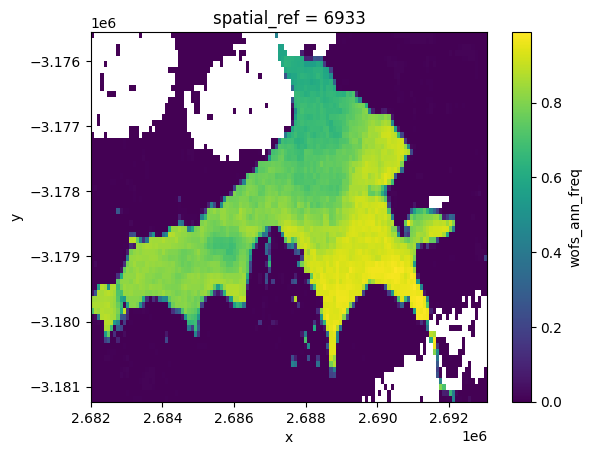

In [663]:
ds_annual.wofs_ann_freq.mean(dim = 'time').plot()

### Floating Algal Index function. 
FAI is  really nice algorithn that detects anomalies in the NIR band by interpolating a base value for NIR from Red and SWIR. It is known to work with TM data.
FAI is less sensitive to atmospheric corrections etc. than NDVI, and provides higher resolution descrimination of photosynthetic surface material.
With MSI a question is which NIR band is best suited, but band 8a seems most okay.
When using the geomedian its not clear what bands are involved : 'nir' and 'nir_narrow' presumably translate to bands 8 and 8a respectively, so it looks like we can go with 8a
The FAI can be calculated with either the 1240 or 1600 swir bands of MODIS, ie
- tm05  lamnda = 1650
- oli06 lamnda = 1610
- msi11 lamnda = 1612

In [664]:
#this version of FAI now replaced by version in WQ_functions.py

In [665]:
# FAI algorithm depends on knowledge of hte central wavelengths of the red, nir, and swir sensors. I include  a dictionary of those values here to keep the function self-contained

def FAI_dev (ds, instrument, test=True):
    inst_bands = ib = {}
    ib['msi']     = {  'red' : ('msi04',     665),          'nir' : ('msi8a',     864),          'swir': ('msi11',     1612)            }
    ib['msi_agm'] = {  'red' : ('msi04_agm', 665),          'nir' : ('msi8a_agm', 864),          'swir': ('msi11_agm', 1612)            }
    ib['oli']     = {  'red' : ('oli04',    (640 + 670)/2), 'nir' : ('oli05',    (850 + 880)/2), 'swir': ('oli06',    (1570 + 1650)/2)  }
    ib['oli_agm'] = {  'red' : ('oli04_agm',(640 + 670)/2), 'nir' : ('oli05_agm',(850 + 880)/2), 'swir': ('oli06_agm',(1570 + 1650)/2)  }
    ib['tm']      = {  'red' : ('tm03',     (630 + 690)/2), 'nir' : ('tm04',     (760 + 900)/2), 'swir': ('tm05',     (1550 + 1750)/2)  }
    ib['tm_agm']  = {  'red' : ('tm03_agm', (630 + 690)/2), 'nir' : ('tm04_agm',(760 + 900)/2),  'swir': ('tm05_agm', (1550 + 1750)/2)  }
    if not instrument in inst_bands.keys():
        print('! -- invalid instrument, FAI will be calculated as zero --- !')
        return(0)
    red, l_red   = ib[instrument]['red'][0], ib[instrument]['red'] [1]
    nir, l_nir   = ib[instrument]['nir'][0], ib[instrument]['nir'] [1]
    swir,l_swir  = ib[instrument]['swir'][0],ib[instrument]['swir'][1]

    if test: 
        print('red : ',red,l_red)
        print('nir : ',nir,l_nir)
        print('swir: ',swir,l_swir)
        print((l_nir - l_red )/(l_swir-l_red))
            
    # --- final value is scaled by 10000 to reduce to a value typically in the range of 0-1     
    return((ds[nir] - ( ds[red] + ( ( ds[swir] - ds[red] ) * ( ( l_nir - l_red ) / ( l_swir - l_red ) ) ) )) / 10000)

In [666]:
# --- run the FAI for each sensor. 
ds['fai'] = ds.wofs_ann_freq  * 0  # --- initiates the array with the correct dimensions
for instrument in ('msi','oli','tm'):
    if instrument in ds.data_vars:
        ds['fai'] = xr.where(ds[instrument],FAI(ds,instrument,test = False),ds.fai)


In [667]:
# --- run the FAI for annual geomedian based datasets --- 
#     In this case multiple fai values are produced, one for each instrument in the geomedian set. 
#     However on the bright side we don't need to use the 'where' statement :)

for instrument in ('msi_agm','oli_agm','tm_agm'):
    if instrument+'_smad' in ds_annual.data_vars:                    # --- i am assuming that the smad will be a variable and using this as a test 
        ds_annual[instrument+'_fai'] = ds_annual.wofs_ann_freq  * 0  # --- initiates the array with the correct dimensions
        ds_annual[instrument+'_fai'] = FAI(ds_annual,instrument,test = False)


In [668]:
#del ds
gc.collect()

61

0
msi


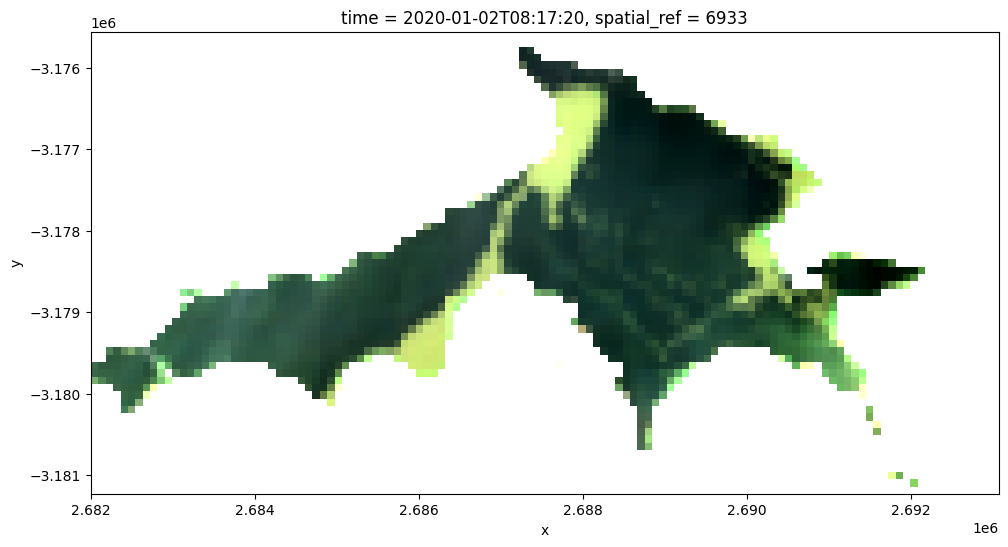

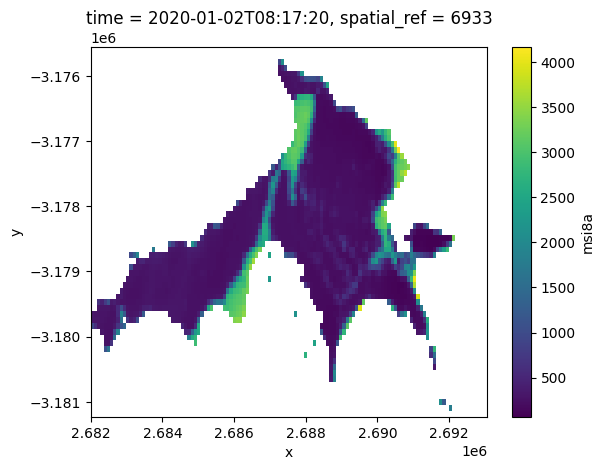

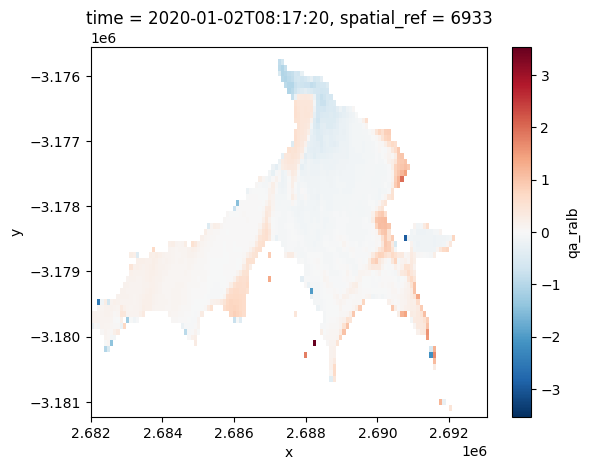

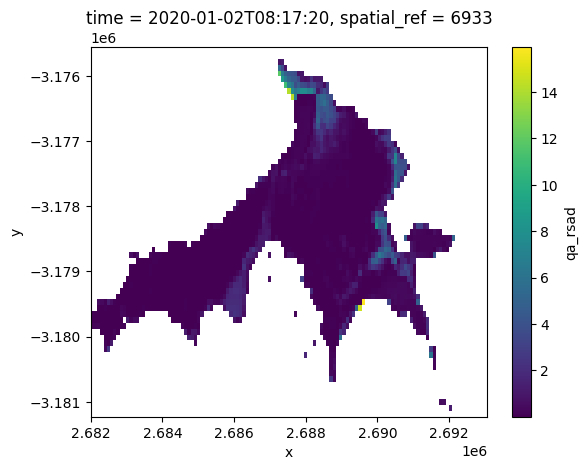

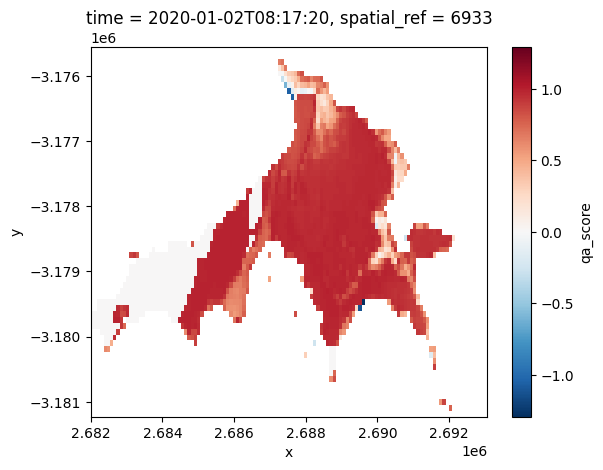

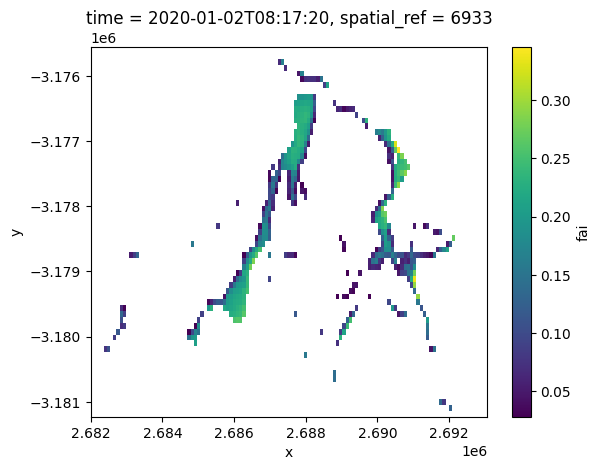

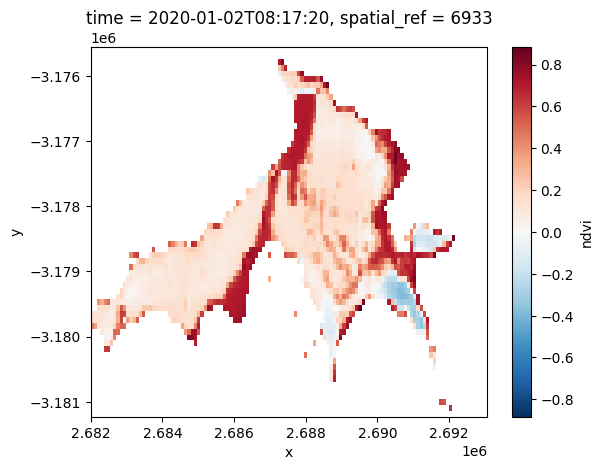

In [671]:
#examine results
i = 0
ds_plot = ds.isel(time = i)

print(i)
if ds_plot.oli: 
    print('oli')
    inst  = 'oli'
    rgb(ds_plot,bands=['oli04','oli03','oli02'],robust = True),plt.show()
    plt.show()
    ds.isel(time=i).oli05.plot()
    plt.show()

if ds_plot.msi: 
    print('msi')
    inst  = 'msi'
    rgb(ds_plot,bands=['msi04','msi03','msi02'],robust = True)
    plt.show()
    ds.isel(time=i).msi8a.plot()
    plt.show()

if ds_plot.tm:  
    print('tm')
    inst  = 'tm'
    rgb(ds_plot,bands=['tm03','tm02','tm01'],robust = True)
    plt.show()
    ds.isel(time=i).tm05.plot()
    plt.show()
    

ds.isel(time=i).qa_ralb.plot()
plt.show()
ds.isel(time=i).qa_rsad.plot()
plt.show()
ds.isel(time=i).qa_score.plot()
plt.show()
ds_plot.where(ds_plot.qa_score > 0).where(ds_plot.fai > cutoff['fai'][inst]).fai.plot()
plt.show()
ds_plot.ndvi.plot(),plt.show()
i = i + 1

In [672]:
# building a dictionary of results, showing each instrument and each measure, mean by month
# later will add the percentage of area with measure above threshold, which requires allowance for the proportion of valid data

cutoff = {
    'ndvi' : {'msi': 0.06417626689906246, 'oli' : 0.0575998312383445, 'tm': 0.08210079534199263},
    'fai'  : {'msi': 0.02794809173030531, 'oli' : 0.0370059408963587, 'tm': 0.05294067859852353},
    }
reference_mean = {
    'ndvi' : {'msi': 0.3268506413577676,  'oli' : 0.3304715643505414,  'tm': 0.2788954907387175},
    'fai'  : {'msi': 0.09706884994492773, 'oli' : 0.10152865645460406, 'tm': 0.09626936881950525},
    }
results = {
    'reference_mean': reference_mean, 
    'cutoff': cutoff, 
    'time':ds.time, 
    'fai_mean' : {},
    'fai_count' : {},
    'ndvi_mean': {},
    'ndvi_count': {},
    'coverage' : ds.qapasspercent / 100. ,
    'total_pixels' : ds.where(ds.wofs_ann_freq>0.5).isel(time=0).wofs_ann_freq.count().item(),
    'pixel_area'   : (ds.x[1] - ds.x[0]) * (ds.y[1] - ds.y[0]) / 10000
    }
results['total_area'] = results['total_pixels'] * results['pixel_area']

cutoff = {
    'ndvi' : {'msi': 0.06417626689906246, 'oli' : 0.0575998312383445, 'tm': 0.08210079534199263},
    'fai'  : {'msi': 0.02794809173030531, 'oli' : 0.0370059408963587, 'tm': 0.05294067859852353},
    }
cutoff_factor = 1  # experiment with this if necessary
reference_mean = {
    'ndvi' : {'msi': 0.3268506413577676,  'oli' : 0.3304715643505414,  'tm': 0.2788954907387175},
    'fai'  : {'msi': 0.09706884994492773, 'oli' : 0.10152865645460406, 'tm': 0.09626936881950525},
    }
for var in 'ndvi','fai':        
    first = True
    for inst in 'tm','oli','msi':
        t = cutoff[var][inst] * cutoff_factor
        # --- calculate results for the instrument, considering only values which pass qa and are above the relevant cut-off
        result_array       = (ds.where(ds.qa_score>0).where(ds[inst]).where(ds[var] > t)[var].mean(dim=('x','y'))) * (reference_mean[var]['msi'] / reference_mean[var][inst])
        # --- resolve cases where no data are above the cut-off, these should be zero rather than nan values.
        result_array       = np.where(~np.isnan(result_array),result_array,np.where(ds[inst],0,np.nan))
        results[var+'_mean'][inst] = result_array

        # --- now calculate the area above the threshold value, scaling up to allow for limited coverage
        result_array       =  (ds.where(ds.qa_score>0).where(ds[inst]).where(ds[var] > t)[var].count(dim=('x','y')) \
            /results['coverage']).astype('int')
        result_array                = result_array.where(ds[inst])  # <--- return nans where this sensor is not applicable
        results[var+'_count'][inst] = result_array

        if first:
            first = False
            inst_all_mean  = results[var+'_mean'][inst]
            inst_all_count = results[var+'_count'][inst]
        else:
            inst_all_mean  = np.where(~np.isnan(inst_all_mean), inst_all_mean, results[var+'_mean'][inst])
            inst_all_count = np.where(~np.isnan(inst_all_count),inst_all_count,results[var+'_count'][inst])
        results[var+'_mean']['all']  = inst_all_mean
        results[var+'_count']['all'] = inst_all_count
        


In [677]:
results['fai_count']['all']

array([ 591.,  474.,  782.,  377.,  346.,  161.,  225.,  281.,  284.,
        226.,  289.,  327.,  208.,  553.,  460.,  340.,  593.,  319.,
        167.,  224.,  249.,  223.,  112.,  273.,  224.,  665.,  121.,
        503.,  996.,  101.,  233.,  274.,  190.,  177.,  300.,  286.,
        278.,   95.,  284.,  785.,  332.,  398.,  536.,   53.,  234.,
        293.,  178.,  171.,   42.,  161.,  552.,  376.,   54.,  174.,
        120.,  269.,  195.,  207.,   77.,  214.,  171.,  217.,   48.,
        136.,  241.,  174.,  143.,  100.,   63.,  187.,  134.,   25.,
         79.,  134.,  182.,  156.,   70.,  128.,   28.,  122.,  123.,
         13.,  117.,   64.,  141.,  146.,  155.,    0.,   97.,   88.,
        112.,   24.,   50.,   96.,  125.,  117.,   53.,   34.,  111.,
        153.,   79.,   26.,  132.,   36.,   95.,  112.,   55.,   85.,
          5.,   69.,   68.,  130.,   13.,   30.,   78.,  125.,   83.,
         43.,   14.,  123.,   85.,  124.,   14.,   47.,   95.,  115.,
         95.,   29.,

In [678]:
#moving average function with the added option to reflect data at the ends to retain a full set of data points 
def moving_average(a, n=3, reflect = True):
    if reflect :
        N = int(n/2)
        s = a.size
        a = np.hstack((a[N:0:-1],a,a[s-2:s-N-2:-1]))
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
    


In [679]:
%run /home/jovyan/AdamsWork/_AL_functions.ipynb

Loading AL_functions


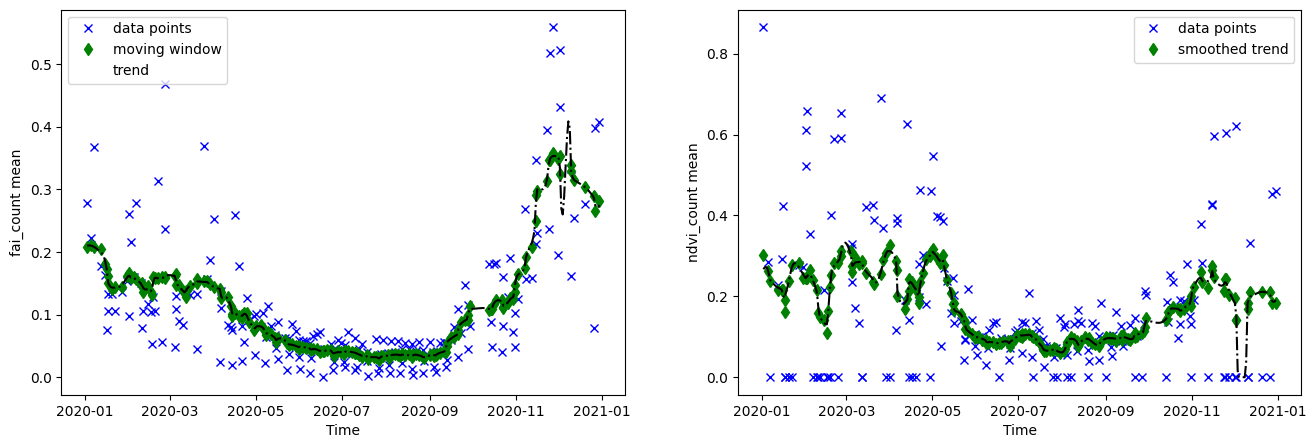

In [682]:
# pull out into a simple array, smooth a couple of times and fit a quadratic spline
#slym = piecewise_linreg(ds.time.astype('float'),lym,keepnans=True,test=False)[0][1]
#sslym = piecewise_linreg(ds.time.astype('float'),slym,keepnans=True,test=False)[0][1]

#smoothed = sp.interpolate.interp1d(ds.time,sslym,kind='cubic',fill_value='extrapolate')
#t_new    = pd.date_range(ds.time.min().values, ds.time.max().values, freq='1D')

smoothing_window = 11   #needs to be an odd number or my function will break!
plt.figure(figsize=[16,5])

plt.subplot(1,2,1)

var = 'fai_count'
plt.xlabel('Time')
plt.ylabel(var+' mean')

# smoothing steps are needed to make a nice graph of these data!
# --- take a moving average window of 5, retain ends
# --- fit a linear piecewise model to take out local peaks and troughs
# --- fit a smooth interpolation, various choices...

data = results[var]['all']/results['total_pixels']
data = np.vstack((data,moving_average(data,smoothing_window)))
#data = np.vstack((results[var]['all']/results['total_pixels'],moving_average(results[var]['all'],5)))
s1   = piecewise_linreg(ds.time.astype('float'),data[1,:],keepnans=True,test=False)[0][1]
data = np.vstack((data,s1))
smoothed = sp.interpolate.interp1d(results['time'],data[2,:],kind='cubic',fill_value='extrapolate')
smoothed = sp.interpolate.Akima1DInterpolator(results['time'],data[2,:],extrapolate=True)
t_days    = pd.date_range(results['time'].min().values, results['time'].max().values, freq='1D')


plt.plot(results['time'],data[0,:],'b',linestyle="", marker="x",label='Data Points')  
plt.plot(results['time'],data[1,:],'g',linestyle="", marker="d",label='Moving Average')  
plt.plot(results['time'],data[2,:],'g',linestyle="", marker="",label='Moving Average')  
plt.plot(t_days         ,smoothed(t_days).clip(0),'k',linestyle="-.", marker="",label='Moving Average')  
#plt.plot(results['time'],data[1,:]/results['coverage'],'r',linestyle="", marker="o",label='Moving Average')  
#plt.plot(t_new,smoothed(t_new),'g',linestyle="--", marker="",label='LYM TSI excess')  

plt.legend(['data points','moving window','trend'])

plt.subplot(1,2,2)

var = 'ndvi_count'
plt.xlabel('Time')
plt.ylabel(var+' mean')

data = results[var]['all']/results['total_pixels']
data = np.vstack((data,moving_average(data,smoothing_window)))
#data = np.vstack((results[var]['all']/results['total_pixels'],moving_average(results[var]['all'],5)))
s1   = piecewise_linreg(ds.time.astype('float'),data[1,:],keepnans=True,test=False)[0][1]
data = np.vstack((data,s1))
smoothed = sp.interpolate.interp1d(results['time'],data[2,:],kind='cubic',fill_value='extrapolate')
smoothed = sp.interpolate.Akima1DInterpolator(results['time'],data[2,:],extrapolate=True)
t_days    = pd.date_range(results['time'].min().values, results['time'].max().values, freq='1D')


plt.plot(results['time'],data[0,:],'b',linestyle="", marker="x",label='Data Points')  
plt.plot(results['time'],data[1,:],'g',linestyle="", marker="d",label='Moving Average')  
plt.plot(results['time'],data[2,:],'g',linestyle="", marker="",label='Moving Average')  
plt.plot(t_days         ,smoothed(t_days).clip(0),'k',linestyle="-.", marker="",label='Moving Average')  
#plt.plot(results['time'],data[1,:]/results['coverage'],'r',linestyle="", marker="o",label='Moving Average')  
#plt.plot(t_new,smoothed(t_new),'g',linestyle="--", marker="",label='LYM TSI excess')  

plt.legend(['data points','moving window','trend'])

plt.legend(['data points','smoothed trend'])




plt.show()

In [347]:
plt.figure(

array([0.27287108, 0.47334559, 0.        , 0.47422291, 0.        ,
       0.26329608, 0.        , 0.        , 0.        , 0.        ,
       0.34257332, 0.26947549, 0.28576586, 0.28901848, 0.32685064,
       0.26273316, 0.        , 0.        , 0.        , 0.        ,
       0.29928915, 0.        , 0.        , 0.        , 0.1721324 ,
       0.3632442 , 0.        , 0.41603971, 0.43405467])

In [338]:
inst_all

array([0.27287108, 0.47334559, 0.08542635, 0.47422291, 0.1042851 ,
       0.26329608, 0.07486879, 0.09402455, 0.07904441, 0.07246558,
       0.34257332, 0.26947549, 0.28576586, 0.28901848, 0.32685064,
       0.26273316, 0.09080321, 0.08958241, 0.08071563, 0.0701747 ,
       0.29928915, 0.07616445, 0.08459333, 0.07620059, 0.1721324 ,
       0.3632442 , 0.06367782, 0.41603971, 0.43405467])

In [302]:
var = 'ndvi'
inst = 'tm'
cutoff = {
    'ndvi' : {'msi': 0.06417626689906246, 'oli' : 0.0575998312383445, 'tm': 0.08210079534199263},
    'fai'  : {'msi': 0.02794809173030531, 'oli' : 0.0370059408963587, 'tm': 0.05294067859852353}
    }

for var in 'ndvi','fai':
    for inst in 'msi','tm','oli':
        t = cutoff[var][inst]
            
        print(
            '\n overall       : ',var,inst, np.nanmean(np.nanmean(ds.where(ds.qa_score>0).where(ds[inst]).where(ds[var]>t)[var])),
            '\n overall       : ',var,inst, ds.where(ds.qa_score>0).where(ds[inst]).where(ds[var]>t)[var].mean().item(),
            )


 overall       :  ndvi msi 0.32685064135776737 
 overall       :  ndvi msi 0.32685064135777686

 overall       :  ndvi tm 0.27889549073871744 
 overall       :  ndvi tm 0.2788954907387165

 overall       :  ndvi oli 0.3304715643505414 
 overall       :  ndvi oli 0.3304715643505416

 overall       :  fai msi 0.09706884994492773 
 overall       :  fai msi 0.09706884994492758

 overall       :  fai tm 0.09626936881950526 
 overall       :  fai tm 0.0962693688195053

 overall       :  fai oli 0.10152865645460407 
 overall       :  fai oli 0.10152865645460392


In [296]:
var     = 'ndvi'
inst    = 'tm' 
cutoff   = 0.082100
print(ds.where(ds[inst]).where(ds.qa_score > 0).where(ds[var]>cutoff)[var].mean().item())



0.2788954907387165


In [48]:
#from : https://github.com/kelemenr/otsu-threshold/blob/main/otsu_threshold.py
# a really elegant implementation, seems to give same results as the scipy version
# the input must not contain nans 

def otsu(gray,n=256):   
    
    hist, bin_edges = np.histogram(gray, bins=n)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0

    w1 = np.cumsum(hist)
    w2 = np.cumsum(hist[::-1])[::-1]

    mu1 = np.cumsum(hist * bin_centers) / w1
    mu2 = (np.cumsum((hist * bin_centers)[::-1]) / w2[::-1])[::-1]

    sigma_total = w1[:-1] * w2[1:] * (mu1[:-1] - mu2[1:]) ** 2

    max_val_index = np.argmax(sigma_total)
    t = bin_centers[:-1][max_val_index]

    return t

In [ ]:
### Analysis using otsu's method.
Over a couple of months at haartbeesport, 30m dataset, we see that msi, oli and tm have different otsu thresholds for ndvi and fai:
In brackets are the implied scaling to match to the msi values.
       NDVI          ,FAI  
Otsu threshold:
- msi: 0.345 (1    ), 0.0788 (1     )
- oli: 0.331 (.9594), 0.0600 (0.7614)
- tm : 0.295 (.8551), 0.0552 (0.7005)
- all together: 0.335, 0.0718
Mean values:
- msi:  0.2701 (1     ), 0.0386 (1    )
- oli:  0.2933 (1.0855), 0.0348 (0.9016)
- tm :  0.2386 (0.8834), 0.0304 (0.7876)

#### This is all curious ... but not sure how to use it yet. Matching of the cumulatve probability functions still seems superior - a step beyond these
#### ALSO, these need to be repeated filtering to qa_score > 0 

In [143]:
print(np.array([.0788,.0600,.0552])/.0788,
      np.array([.0386 ,.0348, .0304])/.0386)
a = True
print(not a)

[1.         0.76142132 0.70050761] [1.         0.9015544  0.78756477]
False


ndvi otsu and mean:  0.285940168260074 0.21821218001647322
fai  otsu and mean:  0.06048137207031252 0.026892533904715812
dataset mean for ndvi, fai:  0.21760942177953993 0.026892533904715587
0.23322874304124047 5.702590174639648e-18 0.41948636506771214


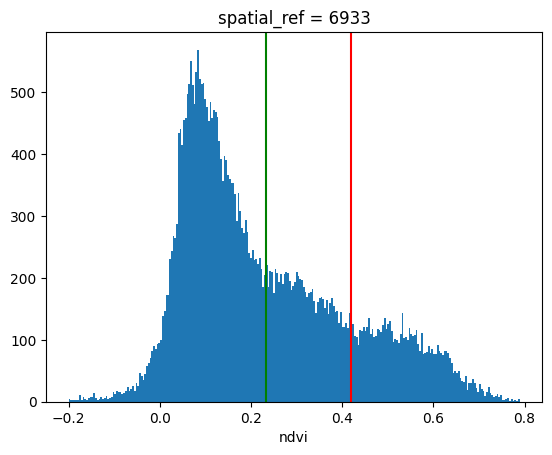

In [183]:
#check that the algorithm is not sensitive to offset and scale - all good!
inst = 'tm'
lower_cut_fai = -0.1
lower_cut_ndvi = -0.2
fai = False
ndvi = not fai
ndvidata = np.asarray(ds.where(ds.qa_score > 0).where(ds.ndvi> lower_cut_ndvi).where(ds[inst]).ndvi).reshape(ds.x.size * ds.y.size * ds.time.size)
faidata  = np.asarray(ds.where(ds.qa_score > 0).where(ds.fai > lower_cut_fai).where(ds[inst]).fai ).reshape(ds.x.size * ds.y.size * ds.time.size)
ndvidata = ndvidata[~np.isnan(ndvidata)]
faidata  = faidata[~np.isnan(faidata)]
print('ndvi otsu and mean: ',otsu(ndvidata,512),np.mean(ndvidata))
print('fai  otsu and mean: ',otsu(faidata,512), np.mean(faidata))
print('dataset mean for ndvi, fai: ',
      (ds.where(ds.qa_score>0).where(ds.ndvi>-1).where(ds[inst])).ndvi.mean().item(),
      (ds.where(ds.qa_score>0).where(ds.fai>-1) .where(ds[inst])).fai .mean().item()
     )

#np.histogram(data)
#plt.hist(data,bins=500)
#xr.plot.hist(ds.where(ds.ndvi>-1  ).where(ds[inst]).ndvi,bins=256)
if fai:
    xr.plot.hist(ds.where(ds.fai > lower_cut_fai).where(ds[inst]).fai,bins=256)
    #plt.axvline(otsu(np.asarray(faidata),512),color='r')
    left = faidata[faidata<np.mean(faidata)]
if ndvi:
    xr.plot.hist(ds.where(ds.ndvi > lower_cut_ndvi).where(ds[inst]).ndvi,bins=256)
    #plt.axvline(otsu(np.asarray(ndvidata),512),color='r')
    left = ndvidata[ndvidata<np.mean(ndvidata)]
right = left * -1
both  = np.array([left,right]).reshape(2 * np.size(left))
cutoff = np.var(both)**0.5 * 2
print(cutoff,np.mean(both),np.mean(ndvidata[ndvidata>cutoff])) 
plt.axvline(cutoff,color='g')
plt.axvline(np.mean(ndvidata[ndvidata>cutoff]),color='r')

plt.show()

#### Finding a natural threshold to cut the FAI and NDVI. 
1. assume that there is noise around the mean (~zero value) and that the noise is symmetric about the mean
2. reflect the left half of that distribution through the mean and model as gaussian, i.e, take the variance.
3. set a threshold at 2sigma above the mean; discard values below that threshold as not significant.
4. the threshold will differ for each sensor

**Then:**

5.  use the overall mean values (per sensor) to adjust tm and msi to the oli values (or some other way)
initial experimentation finds :

**FAI:**

 `instrument threshold        mean overall value above threshold (observed)`
- `msi  0.027948091730305314  0.09706884994492773 `
- `oli  0.03700594089635879   0.10152865645460406`
- `tm   0.05294067859852353   0.09626936881950525`

**NDVI:**

- `msi 0.06417626689906246 0.3268506413577676`                      -- this corresponds best to the observed local minimum.
- `oli 0.0575998312383445  0.3304715643505414`                      -- this cutoff looked natural to me when working with the data, perhaps a bit inclusive
- `tm  0.08210079534199263 0.2788954907387175`                       -- this may need some further experimentation`


In [267]:
# Analysis
for measure in ('fai','ndvi'):
    for inst in ('msi','oli','tm'):
        print(inst,measure,'overall mean : ',ds.where(ds.qa_score>0).where(ds[measure]>-1).where(ds[inst])[measure].mean().item())
        print('inst, msr, lower bound, mean (truncated), cutoff, residual mean : ',ds.where(ds.qa_score>0).where(ds[measure]>-1).where(ds[inst])[measure].mean().item())
        for lower_cut  in (-0.05,-0.1,-0.2,-0.3,-0.4):
            data    = np.asarray(ds.where(ds.qa_score > 0).where(ds[measure]> lower_cut).where(ds[inst])[measure]).reshape(ds.x.size * ds.y.size * ds.time.size)
            data   = data[~np.isnan(data)]
            overallmean = ds.where(ds.qa_score>0).where(ds[measure]>-1).where(ds[inst])[measure].mean().item(),
            if measure == 'fai' :
                left   = data[data < np.mean(data)]
                right  = left * -1
                both   = np.array([left,right]).reshape(2 * np.size(left))
                cutoff = np.mean(data) + np.var(both)**0.5 * 2 
                print(inst,measure,lower_cut,np.mean(data),cutoff,np.mean(data[data>cutoff]))
            if measure == 'ndvi':
                left   = data[data <             0]
                right  = left * -1
                both   = np.array([left,right]).reshape(2 * np.size(left))
                cutoff = 0             + np.var(both)**0.5 * 2 
                print(inst,measure,lower_cut,np.mean(data),cutoff,np.mean(data[data>cutoff])) 

msi fai overall mean :  0.012105979369991178
inst, msr, lower bound, mean (truncated), cutoff, residual mean :  0.012105979369991178
msi fai -0.05 0.012191860521907991 0.027948091730305314 0.09706884994492773
msi fai -0.1 0.012105979369991278 0.028523931937998855 0.09795234574064664
msi fai -0.2 0.012105979369991278 0.028523931937998855 0.09795234574064664
msi fai -0.3 0.012105979369991278 0.028523931937998855 0.09795234574064664
msi fai -0.4 0.012105979369991278 0.028523931937998855 0.09795234574064664
oli fai overall mean :  0.020816970702784304
inst, msr, lower bound, mean (truncated), cutoff, residual mean :  0.020816970702784304
oli fai -0.05 0.02081697070278446 0.03700594089635879 0.10152865645460406
oli fai -0.1 0.02081697070278446 0.03700594089635879 0.10152865645460406
oli fai -0.2 0.02081697070278446 0.03700594089635879 0.10152865645460406
oli fai -0.3 0.02081697070278446 0.03700594089635879 0.10152865645460406
oli fai -0.4 0.02081697070278446 0.03700594089635879 0.1015286564

ndvi otsu and mean:  0.285940168260074 0.21821218001647322
fai  otsu and mean:  0.06048137207031252 0.026892533904715812
dataset mean for ndvi, fai:  0.21760942177953993 0.026892533904715587
0.23322874304124047 5.702590174639648e-18 nan


/opt/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_197922/3617554379.py:34: RuntimeWarning: Mean of empty slice
  plt.axvline(np.nanmean(all[all>cutoff]),color='r')


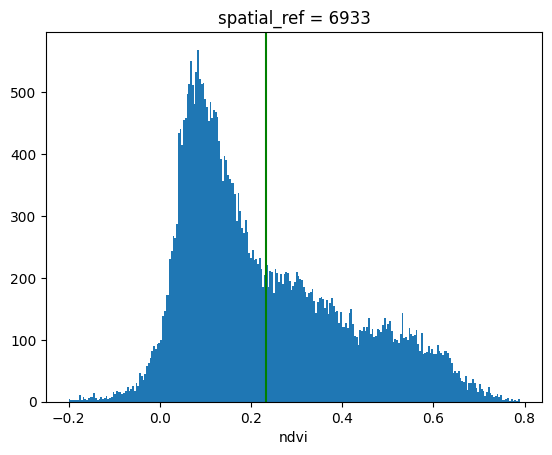

In [ ]:
#RESULTS:
# this is preliminary; might need to re-work if the input data change, e.g., using R corrected data (which should not be necessary)

# full results below. The method for FAI is slightly different. For NDVI I assume zero. For FSI I work from the dataset mean (after truncating which has no effect) because there is a slight positive value.

msi fai overall mean :  0.012105979369991178
inst, msr, lower bound, mean (truncated), cutoff, residual mean :  0.012105979369991178
msi fai -0.05 0.012191860521907991 0.027948091730305314 0.09706884994492773                    --- all negative values are included by here.
msi fai -0.1 0.012105979369991278 0.028523931937998855 0.09795234574064664
msi fai -0.2 0.012105979369991278 0.028523931937998855 0.09795234574064664
msi fai -0.3 0.012105979369991278 0.028523931937998855 0.09795234574064664
msi fai -0.4 0.012105979369991278 0.028523931937998855 0.09795234574064664
oli fai overall mean :  0.020816970702784304
inst, msr, lower bound, mean (truncated), cutoff, residual mean :  0.020816970702784304
oli fai -0.05 0.02081697070278446 0.03700594089635879 0.10152865645460406
oli fai -0.1 0.02081697070278446 0.03700594089635879 0.10152865645460406
oli fai -0.2 0.02081697070278446 0.03700594089635879 0.10152865645460406
oli fai -0.3 0.02081697070278446 0.03700594089635879 0.10152865645460406
oli fai -0.4 0.02081697070278446 0.03700594089635879 0.10152865645460406
tm fai overall mean :  0.026892533904715587
inst, msr, lower bound, mean (truncated), cutoff, residual mean :  0.026892533904715587
tm fai -0.05 0.026892533904715812 0.05294067859852353 0.09626936881950525
tm fai -0.1 0.026892533904715812 0.05294067859852353 0.09626936881950525
tm fai -0.2 0.026892533904715812 0.05294067859852353 0.09626936881950525
tm fai -0.3 0.026892533904715812 0.05294067859852353 0.09626936881950525
tm fai -0.4 0.026892533904715812 0.05294067859852353 0.09626936881950525
msi ndvi overall mean :  0.006248832028445583
inst, msr, lower bound, mean (truncated), cutoff, residual mean :  0.006248832028445583
msi ndvi -0.05 0.21237697423180132 0.06417626689906246 0.3268506413577676                      -- this corresponds best to the observed local minimum.
msi ndvi -0.1 0.16046036199075606 0.11697407248653276 0.3789620347748565
msi ndvi -0.2 0.09869348385160025 0.2130007037574934 0.46747070429835896
msi ndvi -0.3 0.05966392588342217 0.2947467336276085 0.5229066114245087
msi ndvi -0.4 0.03957855904489346 0.34852097725951814 0.5562223095754881
oli ndvi overall mean :  0.1927344933438642
inst, msr, lower bound, mean (truncated), cutoff, residual mean :  0.1927344933438642
oli ndvi -0.05 0.23886144593181127 0.0575998312383445 0.3304715643505414                      -- this cutoff looked natural to me when working with the data, perhaps a bit inclusive
oli ndvi -0.1 0.21286675042189687 0.10316426034290946 0.37075946679865424                      
oli ndvi -0.2 0.1929953523832525 0.15103861113211836 0.40953488424436996
oli ndvi -0.3 0.19273449334386428 0.152398555858341 0.4107678767292981
oli ndvi -0.4 0.19273449334386428 0.152398555858341 0.4107678767292981
tm ndvi overall mean :  0.21760942177953993
inst, msr, lower bound, mean (truncated), cutoff, residual mean :  0.21760942177953993
tm ndvi -0.05 0.2219779725077434 0.048456123089290426 0.2484267419441686
tm ndvi -0.1 0.21985495943937142 0.08210079534199263 0.2788954907387175                       -- perhaps there is rationale for a higher cutoff with TM data  - higher variance
tm ndvi -0.2 0.21821218001647322 0.1278757164834588 0.327210511769253
tm ndvi -0.3 0.2176094217795405 0.15273590881775892 0.3521414505357127
tm ndvi -0.4 0.2176094217795405 0.15273590881775892 0.3521414505357127

In [105]:
left = faidata[faidata<0]
right = left * -1
all = np.array([left,right]).reshape(2 * np.size(left))
np.var(all)**0.5 * 2

0.025191741283764117

In [ ]:
#plot fai and ndvi through time
from  skimage import filters
for t in ds.time:
    fai = np.asarray(ds.sel(time=t).fai).reshape(ds.x.size*ds.y.size)
    print(filters.threshold_otsu(fai[~np.isnan(fai)]))

In [96]:
for t in ds.time:
    fai_array = ds.sel(time=t)
    test = test[~np.isnan(test)]
    print(filters.threshold_otsu(test))

IndexError: 2-dimensional boolean indexing is not supported. 

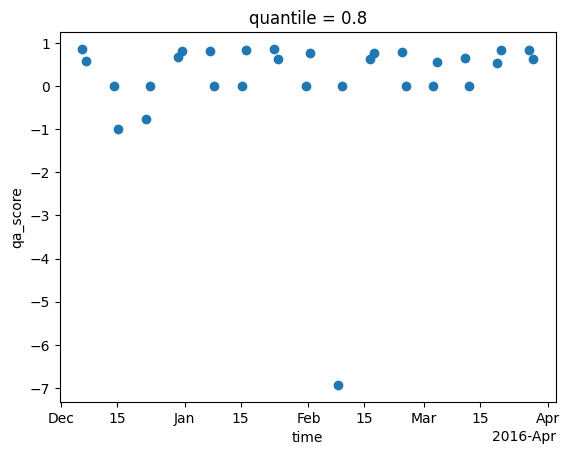

In [140]:
ds.qa_score.quantile(0.8,dim=('x','y')).plot(linestyle  = '',marker='o')

In [ ]:
ds.data_vars


#### Histogram match NDVI values and filter outliers

In [82]:
# --- a function to match histograms --- 'cpf' = cumulative probability function
#     this seems to work well;
#     notice that have to use the xr.qantile method, rather than the np.quantile() function which does not manage the nans!

#     To avoid replicating values it can be necessary for the number of bins to be only 5. A robust work-arond is needed
#    

def cpf_match(source_data,target_data,bins=11,method='quadratic') :
    Q = np.linspace(0,1,bins)         # --- array of quantiles, call it Q. Exclude extreme tails which can be out of range if there are data problems

    # --- calculate the quantiles (CPDs) for the source data and target data
    X = source_data.quantile(Q,skipna= True)
    Y = target_data.quantile(Q,skipna= True)

    # --- fit a model to X; ie Q = f(x)
    f = sp.interpolate.interp1d(X,Q,kind=method,fill_value='extrapolate')
    # --- fit an inverse model to Y; ie Y = g(Q)
    g = sp.interpolate.interp1d(Q,Y,kind=method,fill_value='extrapolate')
    # --- new values are given by g(f(x)), which is very cool 
    
    return xr.DataArray(g(f(source_data)),dims=source_data.dims)
    

In [141]:
# --- Carry out a two-step process of histogram matching over the dataset area.
#     Note that simple regression methods from Francesca Trevisiol et al IEEE TRANSACTIONS ON GEOSCIENCE AND REMOTE SENSING, VOL. 62, 2024
#      don't seem to work here. 
#     Histogram matching methods are inherently local; its only valid to match if the samples have observed the same domain.
#     Modifications are needed to check that there are resonable numbers of observations from each sensor before matching. 

# --- Two step process to leverage the temporal overlaps, first adjust oli to msi, then tm to oli and msi :
# --- further, run the process twice; the first removes extreme values and the second time matches only the positive values
for i in [1,2]:
 
    if 'msi' in ds.data_vars and 'oli' in ds.data_vars : 
    
        # --- first step, harmonise oli to msi, if the latter are available --- 
        ds['ndvi'] = xr.where(ds.oli,
                          cpf_match(ds.ndvi.where(ds.oli,),ds.ndvi.where(ds.msi)),
                          ds.ndvi)

    # --- repeat the process to harmonise the tm data to the adjusted oli data --- 
    if 'tm' in ds.data_vars and 'oli' in ds.data_vars :
        ds['ndvi'] = xr.where(ds.tm,
                          cpf_match(ds.ndvi.where(ds.tm),ds.ndvi.where(ds.oli)),
                          ds.ndvi)

    #--- deal with artefacts of ndvi > 1 ---
    ds['ndvi'] = xr.where(ds.ndvi>1,np.nan,
                      xr.where(ds.ndvi<-1,np.nan,
                               ds.ndvi))

    # --- limit the newly adjusted ndvi data to values above zero ---
    ds['ndvi'] = xr.where(ds.ndvi > 0,ds.ndvi,np.nan)
    

In [ ]:

# --- extract the proporion of the area with ndvi > threshold, indicative of floating photosynthetic material, fpm ---
fpm_threshold = 0.05   # results are not very sensitive to this parameter.... 
fpm_threshold = 0.1   # results are not very sensitive to this parameter.... 

ds['fpm_percent'] = 100 * ds.ndvi.where(ds.ndvi > fpm_threshold,np.nan).count(dim=('x','y')) / ds.ndvi_total_count
# done

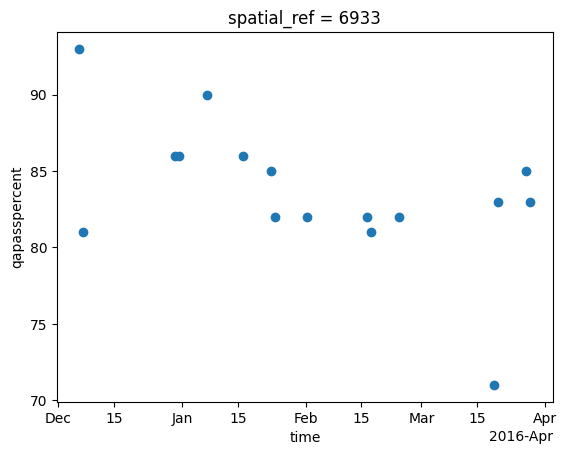

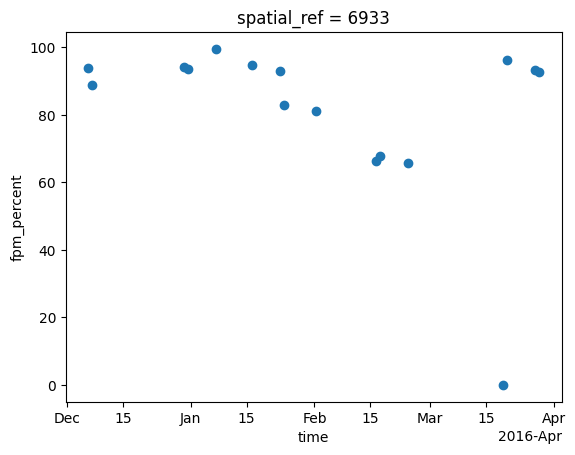

In [137]:
ds.where(ds.qapasspercent>60).qapasspercent.plot(linestyle='',marker='o')
plt.show()
ds.where(ds.qapasspercent>60).fpm_percent.plot(linestyle='',marker='o')
plt.show()
#ds.time.values

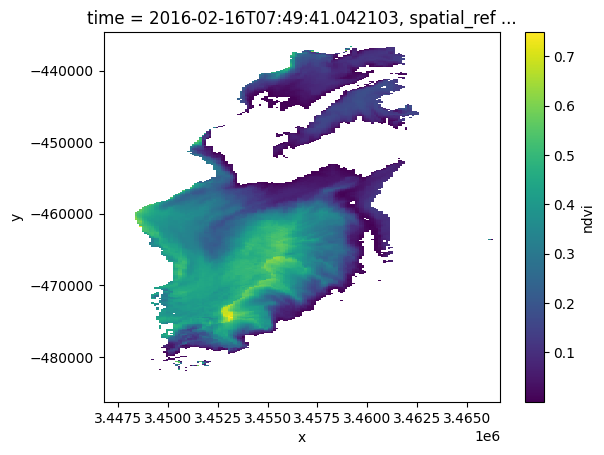

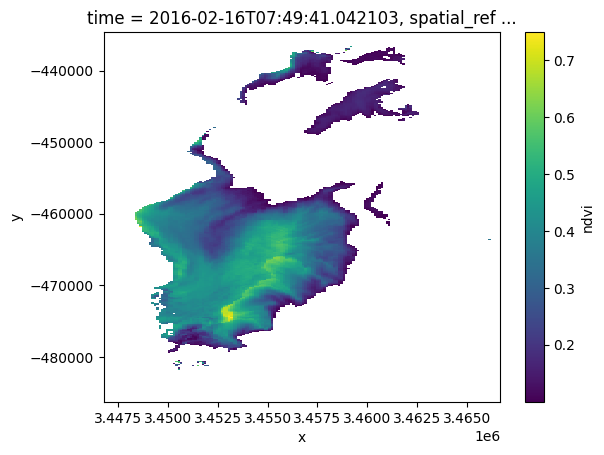

In [143]:
i = i + 1
i = 18
ds.where(ds.ndvi > -1).isel(time=i).ndvi.plot()
plt.show()
ds.where(ds.ndvi > .1).isel(time=i).ndvi.plot()




In [ ]:
ds_annual

#### Run the algorithms - This time for the geomedian dataset

In [118]:
# ---- Apply the WQ algorithms to water areas, adding variables to the dataset and building a list of water quality variable nanmes
# -- this can be run either keeping the wq variables as separate variables on the dataset, or by moving them into new dimensions, 'tss' and 'chla'
# -- If the arguments 'new_dimension_name' or 'new_varname' are None (or empty), then the outputs will be retained as separate variables in a 3d dataset

if True: #put the data into a new dimension, call the variable 'tss' or 'chla'
    ds_annual,tsm_vlist  = WQ_vars(ds_annual.where(ds_annual.wofs_ann_freq >= water_frequency_threshold_low),
                        algorithms_tsm,  
                        instruments_agm, 
                        new_dimension_name='tss_measure', 
                        new_varname='tss', 
                        verbose=verbose)
    
    ds_annual,chla_vlist = WQ_vars(ds_annual.where(ds_annual.wofs_ann_freq >= water_frequency_threshold_low),
                        algorithms_chla, 
                        instruments_agm, 
                        new_dimension_name='chla_measure', 
                        new_varname='chla',
                        verbose=verbose)

else:  #keep it simple, just add new data as new variables in a 3-D dataset  --- this might need debugging!
    ds_annual,tsm_vlist  = WQ_vars(ds_annual.where(ds_annual.wofs_ann_freq >= water_frequency_threshold_low),
                        algorithms_tsm,  
                        instruments_agm, 
                        new_dimension_name=None, 
                        new_varname=None, 
                        verbose=verbose)
    ds_annual,chla_vlist = WQ_vars(ds_annual.where(ds_annual.wofs_ann_freq >= water_frequency_threshold_low),
                        algorithms_chla, 
                        instruments_agm, 
                        new_dimension_name=None, 
                        new_varname=None,
                        verbose=verbose)

wq_varlist = np.append(tsm_vlist,chla_vlist)


In [ ]:
ds_annual

#### Patch up the time-domain variables that were inadvertently expanded to x,y at some point

In [121]:
# ---- percentiles are calculated relative to the number of valid pixels which differes with time because the number of pixels considered valid changes.
ds['ndvi_total_count'] = ds.qa_score.where(np.logical_or(ds['qa_score']>0,~np.isnan(ds['ndvi']))).count(dim=('x','y'))   
ds['qa_percent']       = ((xr.where(ds.qa_score>0,1,np.nan).count(dim=('x','y')) * 100) / water_pixel_count).astype('int')
ds['fpm_percent']      = ds['ndvi'].where(ds.ndvi > fpm_threshold).count(dim=('x','y')) / ds['ndvi_total_count']


### Save the dataset to a file

In [122]:
#export the dataset as an input for the next step:
ds.to_netcdf(dataset_filename)
ds_annual.to_netcdf(dataset_agm_filename)

In [7]:
t = 0

In [9]:
t = t + 1
print(t)
plt.figure(figsize=(4,5))
if ds.isel(time=t).oli:
    inst = 'oli'
if ds.isel(time=t).tm:
    inst = 'tm'
if inst == 'tm' : 
    list = ['ndssi_rg_tm' ,'ti_yu_tm' ,'tsm_lym_tm' ,'spm_qiu_tm' ,'ndci_tm43' ,'chla_modis2b_tm','ndvi']
if inst == 'oli': 
    list = ['ndssi_rg_oli','ti_yu_oli','tsm_lym_oli','spm_qiu_oli','ndci_oli54','ndssi_bnir_oli','tss_zhang_oli','ndvi']
i = 1
for varname in list:
    ds.isel(time=t)[varname].plot(robust=False)
    plt.show()

2


NameError: name 'ds' is not defined

<Figure size 400x500 with 0 Axes>


### Normalise the WQ measures


#### Read in the dataset and parameters

In [10]:
def read_dataset_and_parameters(filename,wq_normalisation_parameters_filename):
    ds   = xr.open_dataset(filename).load(); ds.close()
    with open(wq_normalisation_parameters_filename) as f:
      np_data_dict = json.load(f)
    return(ds,np_data_dict)

In [11]:
# --- A Function to normalise the WQ measures ---

def normalise_water_quality_measures(ds0,np_data_dict,water_frequency_threshold=0,verbose=True,test=False):
    if test or verbose : print('Applying scale and offset to wq variables..')

    ds = ds0.copy(deep=True)   #without this the ds values do change outside of the function

    #run through all the wq measures; ds should have a dimension called 'tss_measure' and another called 'chla_measure'. 
    for mmt_type in ['tss','chla'] :
        for mmt in list(ds[mmt_type+'_measure']) :
            measurement = str(mmt.values)
            scale  = np_data_dict[measurement]['scale']
            offset = np_data_dict[measurement]['offset']
            ds[mmt_type].loc[:,:,:,measurement] = ds[mmt_type].loc[:,:,:,measurement] * scale + offset
    
    #take the median of the tss and chla measurements from now on:
    water_frequency_threshold=0
    tss_index_list  = ds.tss_measure   # --- which tss measures to include; in practice this include them all  ----
    ds['tss_agm_med' ] = xr.where(ds.wofs_ann_freq>water_frequency_threshold,
                                  ds.tss.loc[:,:,:,tss_index_list].median(dim=('tss_measure')),np.nan)

    chla_index_list = ds.chla_measure  # --- which chla measures to include; by default, include them all ----
    ds['chla_agm_med'] = xr.where(ds.wofs_ann_freq>water_frequency_threshold,
                                  ds.chla.loc[:,:,:,chla_index_list].median(dim=('chla_measure')),np.nan)

    #drop excess material
    if False:
        ds = ds.drop_vars(('tss','chla'))
    return ds

In [12]:
# --- Run for the geomedian - important to run these together; don't want to run the normalisation process twice on the same data! ---

ds_annual,np_data_dict = read_dataset_and_parameters(dataset_agm_filename,wq_normalisation_parameters_filename)
ds_annual = normalise_water_quality_measures(ds_annual,np_data_dict,water_frequency_threshold = 0.5,verbose=verbose,test=test)


Applying scale and offset to wq variables..


In [13]:
# --- important to run these together; don't want to run the normalisation process twice on the same data! ---

ds,np_data_dict_sansagm = read_dataset_and_parameters(dataset_filename,wq_normalisation_parameters_filename)

p_data_dict_sansagm = {}
for alg in np_data_dict.keys():
    alg_short = alg[:alg.find('_agm')]
    np_data_dict_sansagm[alg_short] = np_data_dict[alg]     
    
ds = normalise_water_quality_measures(ds,np_data_dict_sansagm,water_frequency_threshold = 0.5,verbose=verbose,test=test)


Applying scale and offset to wq variables..


#### bring in a water test - but this is not effective for some reason (large areas <0), so don't use it.


In [16]:
ds['ndwi_oli'] = (ds.oli04-ds.oli05)/(ds.oli04 + ds.oli05)
ds['ndwi_tm' ] = (ds.tm02 - ds.tm04 )/(ds.tm02  + ds.tm04 )
ds['ndwi']     = xr.where(~np.isnan(ds.ndwi_oli),ds.ndwi_oli,ds.ndwi_tm)
#ds['ndwi_msi'] = (ds.msi03 - ds.msi8a) / (ds.msi03 + ds.msi8a)

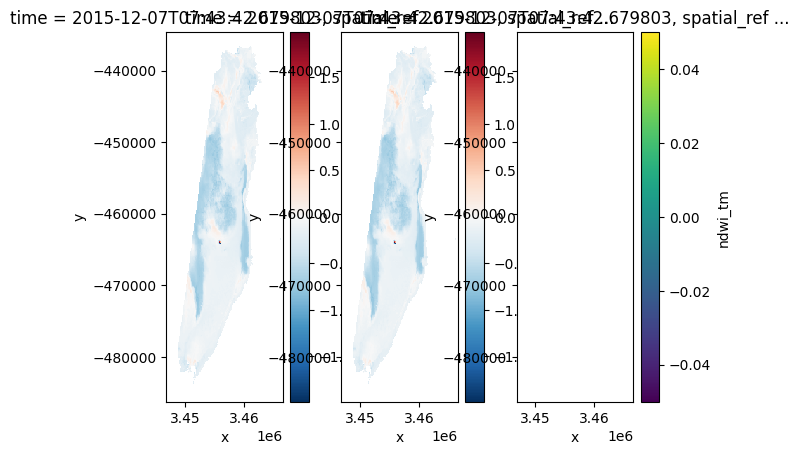

In [17]:
t = 0
t = t + 1
plt.subplot(1,3,1)
ds.isel(time=t).ndwi.plot()
plt.subplot(1,3,2)
ds.isel(time=t).ndwi_oli.plot()
plt.subplot(1,3,3)
ds.isel(time=t).ndwi_tm.plot()

    

In [12]:
ds.tss_measure

<xarray.DataArray 'tss_measure' (tss_measure: 10)> Size: 560B
array(['ndssi_rg_oli', 'ndssi_rg_tm', 'ndssi_bnir_oli', 'ti_yu_oli',
       'ti_yu_tm', 'tsm_lym_oli', 'tsm_lym_tm', 'tss_zhang_oli', 'spm_qiu_oli',
       'spm_qiu_tm'], dtype='<U14')
Coordinates:
    spatial_ref  int32 4B 6933
  * tss_measure  (tss_measure) <U14 560B 'ndssi_rg_oli' ... 'spm_qiu_tm'

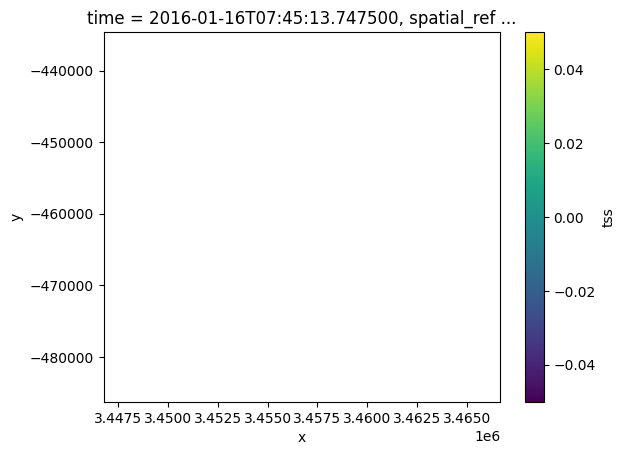

In [202]:
ds.where(ds.qa_score>0).tss.loc[{'tss_measure' : 'tsm_lym_oli'}].isel(time=t).plot()

#### Some derived variables to simplify the plotting process 

In [21]:
# going one step further here; pull out each tss variable, calibrate it to the lymburner distribution, take the median
ds['refvar'] = ds.where(ds.qa_score > 0).tss.loc[{'tss_measure' : 'tsm_lym_oli'}]
i = 0
Q = .8
for tssvar in ds.tss_measure[:] :
    
    # pull out values as a new variable
    ds['tempvar'] = ds.where(ds.qa_score > 0).tss.loc[{'tss_measure' : tssvar}]
    # match that variable to the target (lymburner) distribution
    ds['tempvar'] = cpf_match(ds.tempvar,ds.refvar,5)
    # push it back to the source variable space
    if not tssvar == 'tsm_lym_oli':
        ds.tss.loc[{'tss_measure' : tssvar}] = ds.tempvar
        print('updating ',tssvar.item())




updating  ndssi_rg_oli
updating  ndssi_rg_tm
updating  ndssi_bnir_oli
updating  ti_yu_oli
updating  ti_yu_tm
updating  tsm_lym_tm
updating  tss_zhang_oli


/opt/venv/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


updating  spm_qiu_oli
updating  spm_qiu_tm


/opt/venv/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


0 ndssi_rg_oli


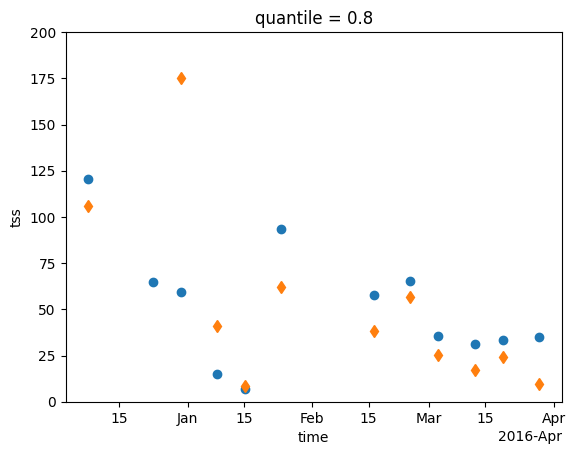

In [65]:
i = -1
i = i +1 

if i < ds.tss_measure.size:
    tssvar  = ds.tss_measure[i].item()
    print(i,tssvar)
    
    ds.where(ds.qa_score>0).tss.loc[{'tss_measure' : 'tsm_lym_oli'}].quantile(Q,dim=('x','y')).plot(marker = 'o',linestyle = '',ylim=(0,200))
#    ds['tss_lym_oli'].quantile(Q,dim=('x','y')).plot(marker = 'x',linestyle = '',color = 'k',ylim=(0,200))
    ds.where(ds.qa_score>0).tss.loc[{'tss_measure' : tssvar}].quantile(Q,dim=('x','y')).plot(marker = 'd',linestyle = '',ylim=(0,200))
    

In [ ]:
ds.tempvar.quantile(Q,dim=('x','y')).plot(marker = 'o',linestyle = '',ylim=(0,200))
ds.refvar.quantile(Q,dim=('x','y')).plot(marker = 'x',linestyle = '',color = 'k',ylim=(0,200))
ds.where(ds.qa_score>0).tss.loc[{'tss_measure' : tssvar}].quantile(Q,dim=('x','y')).plot(marker = 'd',linestyle = '',ylim=(0,200))
i = i + 1
print(tssvar.item(),'tsm_lym_oli',tssvar.item())

In [ ]:
# capture the median value of tss as a variable to simplify future work...
ds['tss_median']            = ds.where(ds.qa_score>0)       .tss.median(dim=('tss_measure'))
ds_annual['tss_agm_median'] = ds_annual.tss.median(dim=('tss_measure')).isel(time=1)

ds['tss_excess'] = ds.tss_median.where(ds.tss_median > ds_annual.tss_agm_median) - ds_annual.tss_agm_median

In [176]:
(ds.lym + 35.1 - ds_annual.tss_agm_median).quantile(.5,dim=('x','y'))

<xarray.DataArray (time: 24)> Size: 192B
array([ 0.26103407, 10.75413415, -0.63003275,  3.00717317, -1.41420258,
       -6.67835658, -5.63744713, -7.778738  , -4.04144488,  0.49081356,
        1.12350316,  6.99861018,  3.28926277,  0.87057734,  2.90172865,
        1.62408231, -1.99528972, -1.09788183,  4.06287482, -2.90542132,
        0.09298646, -2.49635864, 10.75755893,  4.05491538])
Coordinates:
  * time      (time) datetime64[ns] 192B 2015-12-06T07:50:46.715176 ... 2016-...
    quantile  float64 8B 0.5

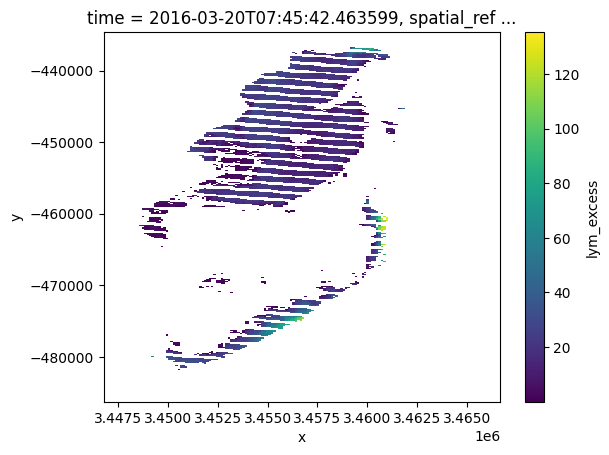

In [201]:
#t = 0
t = t + 1
ds.lym_excess.isel(time=t).plot()

In [97]:
%run /home/jovyan/AdamsWork/_AL_functions.ipynb

Loading AL_functions


In [99]:
ds.time.astype('float')

<xarray.DataArray 'time' (time: 24)> Size: 192B
array([1.44938825e+18, 1.44947422e+18, 1.45085662e+18, 1.45146179e+18,
       1.45154790e+18, 1.45215308e+18, 1.45223902e+18, 1.45284419e+18,
       1.45293031e+18, 1.45353549e+18, 1.45362142e+18, 1.45431272e+18,
       1.45560898e+18, 1.45569513e+18, 1.45630030e+18, 1.45638621e+18,
       1.45699138e+18, 1.45707753e+18, 1.45768271e+18, 1.45776861e+18,
       1.45837377e+18, 1.45845994e+18, 1.45906511e+18, 1.45915100e+18])
Coordinates:
  * time         (time) datetime64[ns] 192B 2015-12-06T07:50:46.715176 ... 20...
    spatial_ref  int32 4B 6933

In [104]:
piecewise_linreg(ds.time.astype('float'),means,keepnans=True,test=False)[0][1]

array([108.073, 108.08 , 127.734, 116.118,  98.282, 117.437, 146.435,
       134.781,  95.285,  71.041,  64.827,  57.821,  50.883,  44.283,
        39.332,  56.348,  71.043,  52.794,  50.876,  85.195,  85.64 ,
        38.864,  18.179,  18.18 ])

In [126]:
means.mean()

<xarray.DataArray 'tss_excess' ()> Size: 8B
array(77.17546667)
Coordinates:
    spatial_ref  int32 4B 6933

In [250]:
for i in np.arange(0,ds.time.size):
    print(i, ds.time[i].values,lym[i].values,ds.lym_excess.mean(dim=('x','y'))[i].values)

0 2015-12-06T07:50:46.715176000 54.41800148459096 54.41800148459096
1 2015-12-07T07:43:42.679803000 77.3319821553746 77.3319821553746
2 2015-12-23T07:43:43.494509000 58.32205309198826 58.32205309198826
3 2015-12-30T07:49:52.823376000 46.767687227911104 46.767687227911104
4 2015-12-31T07:44:58.398838000 48.747003674383215 48.747003674383215
5 2016-01-07T07:51:16.617310000 45.37818146883876 45.37818146883876
6 2016-01-08T07:43:38.668061000 33.54633450937599 33.54633450937599
7 2016-01-15T07:49:50.839894000 26.369649195794878 26.369649195794878
8 2016-01-16T07:45:13.747500000 22.893534868214935 22.893534868214935
9 2016-01-23T07:51:29.503810000 41.955714710490476 41.955714710490476
10 2016-01-24T07:43:39.921891000 59.744399750792546 59.744399750792546
11 2016-02-01T07:45:23.506272000 52.01385777413965 52.01385777413965
12 2016-02-16T07:49:41.042103000 42.04853071354155 42.04853071354155
13 2016-02-17T07:45:27.599780000 44.93310111478829 44.93310111478829
14 2016-02-24T07:51:38.430596000 3

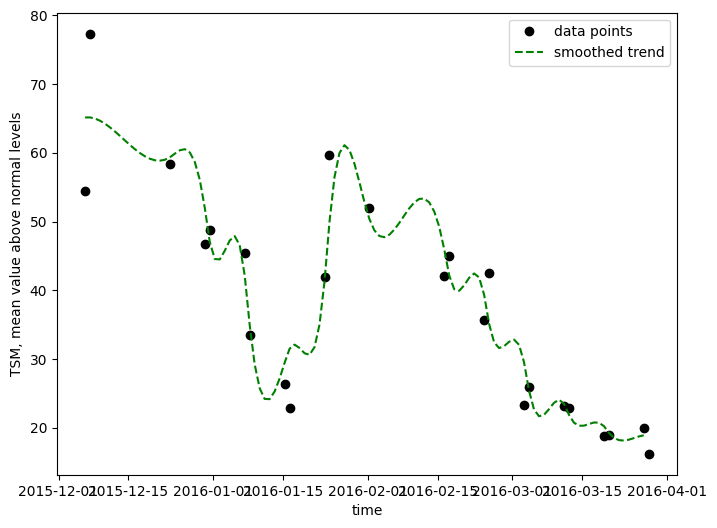

In [236]:
# use the lymburner TSI algorithm for now because it produces consistent results. 

ds['lym']        = ds.where(ds.qa_score>0).tss.loc[{'tss_measure' : ['tsm_lym_oli','tsm_lym_tm']}].median(dim=('tss_measure'))

# 35.1 is the bias between the annual geomedian values and the median values observed here using the lymburner model
ds['lym_excess'] = ds.where(ds.qa_score>0).where(ds.lym + 35.1 > ds_annual.tss_agm_median).lym - ds_annual.tss_agm_median + 35.1

# pull out into a simple array, smooth a couple of times and fit a quadratic spline
lym = ds.where(ds.qa_score>0).lym_excess.mean(dim=('x','y'))
slym = piecewise_linreg(ds.time.astype('float'),lym,keepnans=True,test=False)[0][1]
sslym = piecewise_linreg(ds.time.astype('float'),slym,keepnans=True,test=False)[0][1]

smoothed = sp.interpolate.interp1d(ds.time,sslym,kind='cubic',fill_value='extrapolate')
t_new    = pd.date_range(ds.time.min().values, ds.time.max().values, freq='1D')

plt.figure(figsize=[8,6])
plt.subplot(1,1,1)

plt.xlabel('time')
plt.ylabel('TSM, mean value above normal levels')

plt.plot(ds.time,lym,'k',linestyle="", marker="o",label='Data Points')  
#plt.plot(ds.time,slym,'b',linestyle="", marker="o",label='LYM TSI excess')  
plt.plot(t_new,smoothed(t_new),'g',linestyle="--", marker="",label='LYM TSI excess')  




plt.legend(['data points','smoothed trend'])

#plt.plot(ts_ndvi_tm.time,ts_ndvi_tm,)  



plt.show()

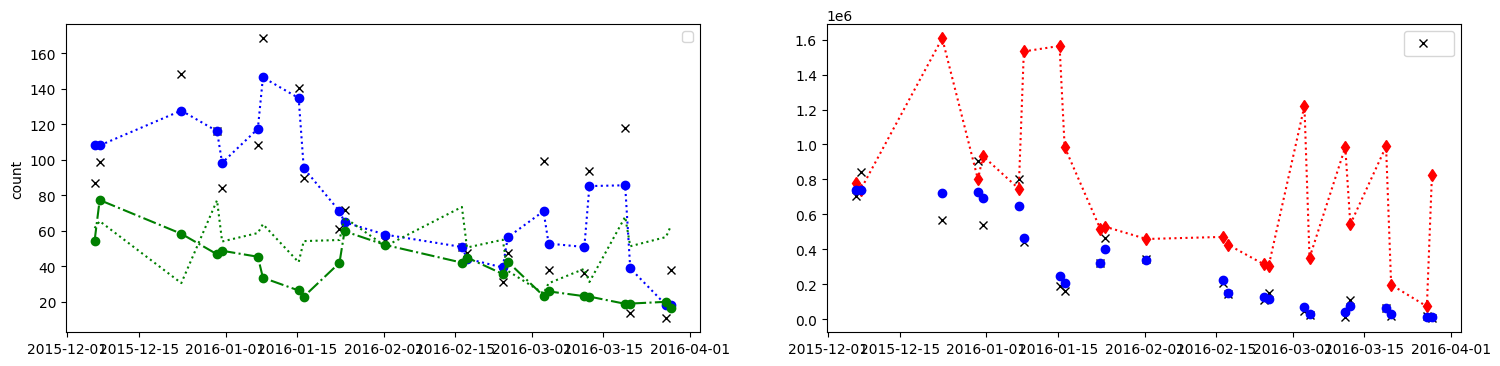

In [202]:
excess_counts  = ds.where(ds.qa_score>0).where(ds.tss_median > ds_annual.tss_agm_median).tss_median.count(dim=('x','y'))
clear_counts   = ds.where(ds.qa_score>0).tss_median.count(dim=('x','y'))
maxclearcounts = clear_counts.max()
area_excess    = excess_counts/clear_counts  * maxclearcounts
confidence     = clear_counts / maxclearcounts

means  = ds.tss_excess.mean(dim=('x','y'))
totals = ds.tss_excess.sum(dim=('x','y'))
smeans = piecewise_linreg(ds.time.astype('float'),means,keepnans=True,test=False)[0][1]
swmeans = piecewise_linreg(ds.time.astype('float'),means*confidence,keepnans=True,test=False)[0][1] / confidence
maxcount = counts.max()

#confidence = ds.where(ds.qa_score>0).where(ds.tss_median > ds_annual.tss_agm_median).tss_median.count(dim=('x','y'))

stotals = piecewise_linreg(ds.time.astype('float'),totals,keepnans=True,test=False)[0][1]
nstotals = piecewise_linreg(ds.time.astype('float'),totals,keepnans=True,test=False)[0][1]/counts * maxcount



plt.figure(figsize=[18,4])
plt.subplot(1,2,1)

plt.xlabel('')
plt.ylabel('count')
plt.legend(['number of pixels contributing to the estimate'])

plt.plot(ds.time,means,'k',linestyle="", marker="x",label='Means')  
plt.plot(ds.time,smeans,'b',linestyle=":", marker="o",label='Smoothed Means')  
plt.plot(ds.time,ds.lym_excess.mean(dim=('x','y')),'g',linestyle="-.", marker="o",label='LYM TSI excess')  
#plt.plot(ds.time,swmeans,'r',linestyle=":", marker="d",label='Smoothed Means')  
#plt.plot(ds.time,smoothfunction(ds.fpm_percent,5)(ds.time),'k',linestyle="--", marker="",label='Smoothed NDVI')  
#plt.legend(['mean excess mg/l','smoothed means','smoothed weighted means'])
plt.plot(ds.time,confidence * means.mean(),'g',linestyle =':')

plt.subplot(1,2,2)
plt.plot(ds.time,totals,'k',linestyle="", marker="x",label='total observed excess')  
plt.plot(ds.time,nstotals,'r',linestyle=":", marker="d",label='smoothed total excess normalised by count')  
plt.plot(ds.time,stotals,'b',linestyle="", marker="o",label='confidence')  



plt.legend([''])

#plt.plot(ts_ndvi_tm.time,ts_ndvi_tm,)  



plt.show()

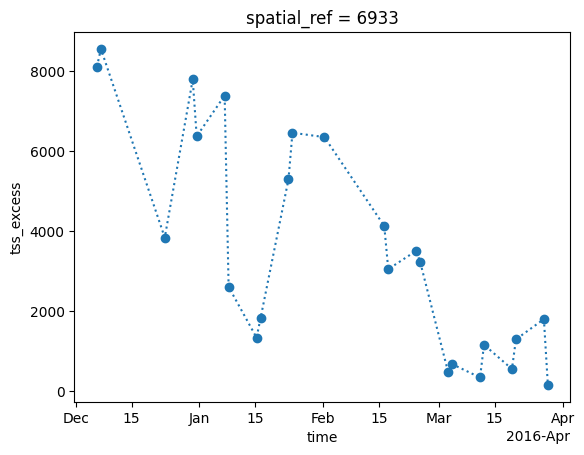

In [86]:
ds.tss_excess.count(dim=('x','y')).plot(marker = 'o',linestyle=':')

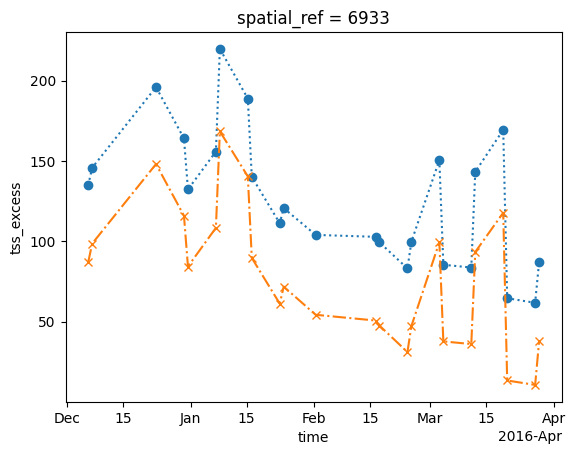

In [81]:
ds.where(ds.qa_score>0).where(ds.tss_median > ds_annual.tss_agm_median).tss_median .mean(dim=('x','y')).plot(linestyle=':',marker='o')
ds.where(ds.qa_score>0).tss_excess .mean(dim=('x','y')).plot(linestyle='-.',marker='x')



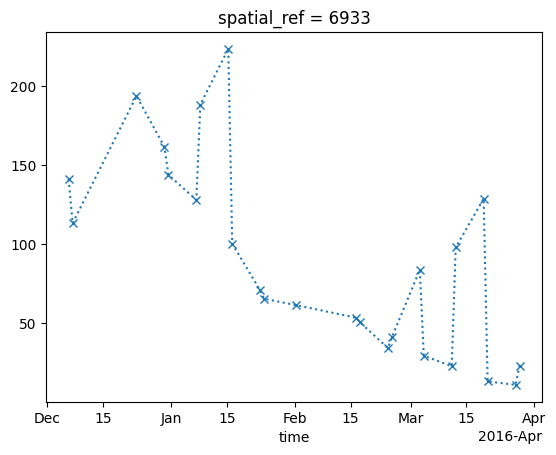

In [72]:
# restricting to the northern half of the lake gives a better response
plt.title=('tss excedences in the northern half of the lake')
(ds.where(ds.qa_score>0).tss_excess[:,300:,:] - ds_annual['tss_agm_median']).mean(dim=('x','y')) \
     .plot(linestyle=':',marker='x')

plt.show()


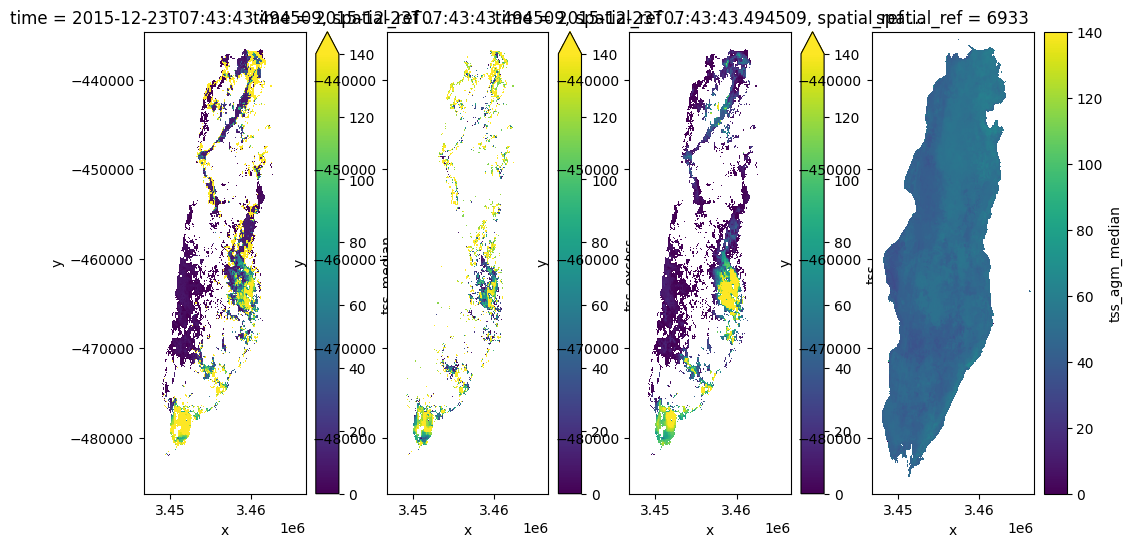

In [90]:
t = t +1
#t = 0
plt.figure(figsize=(12,6))
plt.subplot(1,4,1)
#ds.where(ds.qa_score>0).isel(time=t).tss.median(dim=('tss_measure')).plot(vmin=0,vmax = 140,robust=True)
ds.where(ds.qa_score>0).isel(time=t).tss_median.plot(vmin=0,vmax = 140,robust=True)
plt.subplot(1,4,2)
#ds.where(ds.qa_score>0).where(ds.tss_median > ds_annual.tss_agm_median).isel(time=t).tss_median.plot(vmin=0,vmax = 140,robust=True)
ds.where(ds.qa_score>0).isel(time=t).tss_excess.plot(vmin=0,vmax = 140,robust=True)
plt.subplot(1,4,3)
ds.where(ds.qa_score>0).tss.loc[{'tss_measure' : 'tsm_lym_oli'}].isel(time=t).plot(vmin=0,vmax = 140,robust=True)
plt.subplot(1,4,4)
#ds_annual.tss.median(dim=('time','tss_measure')).plot(vmin=0,vmax=140)
ds_annual.tss_agm_median.plot(vmin=0,vmax=140)


In [244]:
%run /home/jovyan/AdamsWork/_AL_functions.ipynb

Loading AL_functions


In [245]:
# --- a function to produce a smoothed timeseries graph ---
#     the data should be a single-dimenson dataarray with times

def smoothfunction(data,iterations=2):
    xy = piecewise_linreg(\
        data.time.astype('float'),\
        data,\
        keepnans=True)[0]
     
    for i in np.arange(0,iterations):
        xy = piecewise_linreg(\
            data.time.astype('float'),\
            xy[1],\
            keepnans=True)[0]

    # --- extract the valid values and fit a quadratic to them
    xlist = [] ; ylist = []
    for i in range(0,data.time.size):
        if ~np.isnan(xy[1][i]) :
             xlist.append(data.time[i].values)
             ylist.append(xy[1][i])

    xlist = np.asarray(xlist)
    ylist = np.asarray(ylist)
 
    q_interp   = sp.interpolate.interp1d(xlist,ylist,kind='quadratic',fill_value='extrapolate')
    #re-process through the smoother..
    xy = piecewise_linreg(\
        np.arange(0,data.time.size),\
        q_interp(data.time),\
        keepnans=True)[0]
    
    xlist = [] ; ylist = []
    for i in range(0,data.time.size):
        if ~np.isnan(xy[1][i]) :
             xlist.append(data.time[i].values)
             ylist.append(xy[1][i])
    xlist = np.asarray(xlist)
    ylist = np.asarray(ylist)
    return sp.interpolate.interp1d(xlist,ylist,kind='slinear',fill_value='extrapolate')

In [173]:
# make a time-series summary for the water area:
ts_ndvi_tm = ds.where(ds.tm).ndvi.mean(dim=('x','y'))
ts_ndvi_oli = ds.where(ds.oli).ndvi.mean(dim=('x','y'))
#ts_ndvi_msi = ds.where(ds.msi).ndvi.mean(dim=('x','y'))
ts_ndvi     = ds.ndvi.mean(dim=('x','y'))

In [234]:
tss_data = ds.where(ds.qa_score>0).tss.median(dim=('tss_measure','x','y'))

<xarray.DataArray 'tss' (time: 24)> Size: 192B
array([73.13248964, 47.90248981, 38.64781265, 48.16363038, 71.47167219,
       72.56756283, 38.10253846, 11.33066666, 36.82881214, 65.70080135,
       37.60550318, 75.77363794, 38.12856539, 45.46132685, 44.09911217,
       37.61302072, 24.87930519, 28.68209091, 43.23499118, 30.77161373,
       37.02688195, 48.87970975, 58.78127379, 37.78580939])
Coordinates:
  * time         (time) datetime64[ns] 192B 2015-12-06T07:50:46.715176 ... 20...
    spatial_ref  int32 4B 6933

In [268]:
ds_annual

<xarray.Dataset> Size: 31MB
Dimensions:              (time: 2, y: 430, x: 166, tss_measure: 6,
                          chla_measure: 1)
Coordinates:
  * time                 (time) datetime64[ns] 16B 2015-07-02T11:59:59.999999...
  * y                    (y) float64 3kB -4.862e+05 -4.861e+05 ... -4.347e+05
  * x                    (x) float64 1kB 3.447e+06 3.447e+06 ... 3.467e+06
    spatial_ref          int32 4B 6933
  * tss_measure          (tss_measure) <U18 432B 'ndssi_rg_oli_agm' ... 'spm_...
  * chla_measure         (chla_measure) <U14 56B 'ndci_oli54_agm'
Data variables: (12/26)
    oli02_agm            (time, y, x) float64 1MB nan nan nan ... nan nan nan
    oli03_agm            (time, y, x) float64 1MB nan nan nan ... nan nan nan
    oli04_agm            (time, y, x) float64 1MB nan nan nan ... nan nan nan
    oli05_agm            (time, y, x) float64 1MB nan nan nan ... nan nan nan
    oli06_agm            (time, y, x) float64 1MB nan nan nan ... nan nan nan
    oli07_agm            (time, y, x) float64 1MB nan nan nan ... nan nan nan
    ...                   ...
    oli03_agmr           (time, y, x) float64 1MB nan nan nan ... nan nan nan
    oli02_agmr           (time, y, x) float64 1MB nan nan nan ... nan nan nan
    tss                  (time, y, x, tss_measure) float64 7MB nan nan ... nan
    chla                 (time, y, x, chla_measure) float64 1MB nan nan ... nan
    tss_agm_med          (time, y, x) float64 1MB nan nan nan ... nan nan nan
    chla_agm_med         (time, y, x) float64 1MB nan nan nan ... nan nan nan
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

In [278]:
ds['lym'] = ds.where(ds.qa_score>0).tss.loc[{'tss_measure' : 'tsm_lym_oli'}]
ds['lym_delta'] = ds.lym - ds_annual.tss.loc[{'tss_measure' : 'tsm_lym_oli_agm'}].mean(dim='time')

In [280]:
ds.lym_delta.mean(dim=('x','y'))

<xarray.DataArray 'lym_delta' (time: 24)> Size: 192B
array([         nan,  18.05933895,  -4.57568718,  -2.45712517,
                nan,          nan, -25.97221573, -33.71519756,
                nan,          nan,   1.96146237,          nan,
        -3.12984779,          nan,          nan,  -8.10640689,
       -23.06861342,          nan,          nan, -23.52105842,
       -20.59099846,          nan,          nan, -19.07834044])
Coordinates:
  * time         (time) datetime64[ns] 192B 2015-12-06T07:50:46.715176 ... 20...
    spatial_ref  int32 4B 6933

In [276]:
ds_annual.tss.loc[{'tss_measure' : 'tsm_lym_oli_agm'}].mean(dim='time')

<xarray.DataArray 'tss' (y: 430, x: 166)> Size: 571kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y            (y) float64 3kB -4.862e+05 -4.861e+05 ... -4.348e+05 -4.347e+05
  * x            (x) float64 1kB 3.447e+06 3.447e+06 ... 3.466e+06 3.467e+06
    spatial_ref  int32 4B 6933
    tss_measure  <U18 72B 'tsm_lym_oli_agm'

(-100.0, 200.0)

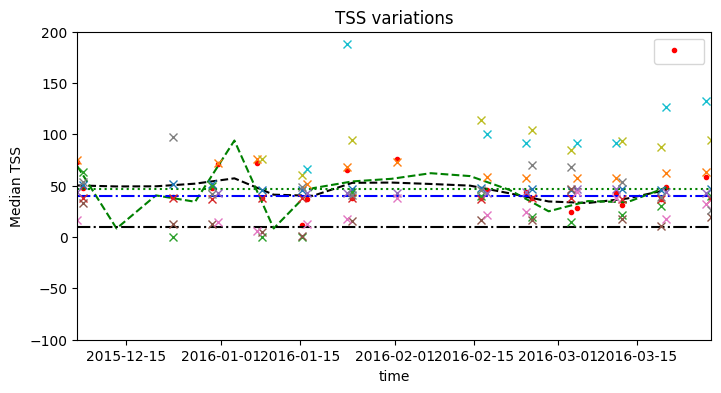

In [267]:
plt.figure(figsize=[18,4])
plt.subplot(1,2,1)
ds['lym'] = ds.where(ds.qa_score>0).tss.loc[{'tss_measure' : 'tsm_lym_oli'}]
ds['lym_delta'] = ds.lym - ds_annual.tss.loc[{'tss_measure' : 'tsm_lym_oli_agm'}]




tssdata        = ds.where(ds.qa_score>0).tss.median(dim=('tss_measure','x','y'))
tsslym         = ds.where(ds.qa_score>0).tss.loc[{'tss_measure' : 'tsm_lym_oli'}].median(dim=('x','y'))
tssdata        = ds.where(ds.qa_score>0).tss.median(dim=('tss_measure','x','y'))


t              = tssdata.time
t_new          = pd.date_range(t.time.min().values, t.max().values, freq='W')  
tss_interp     = sp.interpolate.interp1d(t,(piecewise_linreg(np.arange(0,t.size),tssdata)[0][1]),kind='quadratic',fill_value='extrapolate')
tss_intlym     = sp.interpolate.interp1d(t,(piecewise_linreg(np.arange(0,t.size),tsslym)[0][1]),kind='quadratic',fill_value='extrapolate')



plt.plot(t,tssdata,'r',linestyle="", marker=".",label='')  
plt.plot(t_new,smoothfunction(tssdata,1)(t_new),'k',linestyle="--", marker="",label='Smoothed NDVI')  
plt.plot(t_new,tss_interp(t_new),'g',linestyle="--", marker="",label='Smoothed NDVI')  
plt.plot(t_new,tss_intlym(t_new),'g',linestyle="--", marker="",label='Smoothed NDVI')  

plt.axhline(y=ds_annual.tss.median(),color='g',linestyle=':')
plt.axhline(y=ds_annual.tss.loc[{'tss_measure' : 'tsm_lym_oli_agm'}].median(),color='b',linestyle='-.')
plt.axhline(y=ds       .where(ds.qa_score>0).tss.loc[{'tss_measure' : 'tsm_lym_oli'    }].median(),color='k',linestyle='-.')

set_hue = ds.tss_measure
plt.plot(t,ds.tss.median(dim=('x','y')),linestyle='',marker='x')
#set_hue=wq_summary.tss_measure
#ax1.plot(wq_summary.time,wq_summary['tss']
#         .loc[placename,:],linestyle='dotted')
#ax1.plot(wq_summary.time,wq_summary['tss']
#         .loc[placename,:].
#         median(dim='tss_measure'),linestyle='solid')

plt.title('TSS variations')
                 
plt.xlabel('time')
plt.ylabel('Median TSS')
plt.legend([''])

# --- parameters for the range of the plot --- 
ymin  = -100;
ymax  = 200
xmin,xmax   = np.min(t),np.max(t)

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

In [ ]:
plt.figure(figsize=[18,4])
plt.subplot(1,2,1)

data = ts_ndvi
t    = ts_ndvi.time
plt.plot(ts_ndvi_tm.time,ts_ndvi_tm,'r',linestyle="", marker=".",label='Mean NDVI - TM')  
plt.plot(ts_ndvi_oli.time,ts_ndvi_oli,'g',linestyle="", marker=".",label='Mean NDVI')  
#plt.plot(ts_ndvi_msi.time,ts_ndvi_msi,'b',linestyle="", marker=".",label='Mean NDVI')  
#plt.plot(ts_ndvi.time,smoothfunction(ts_ndvi_tm)(ts_ndvi.time),'r',linestyle=":", marker="",label='Smoothed NDVI')  
#plt.plot(ts_ndvi.time,smoothfunction(ts_ndvi_oli)(ts_ndvi.time),'g',linestyle=":", marker="",label='Smoothed NDVI')  
#plt.plot(ts_ndvi.time,smoothfunction(ts_ndvi_msi,4)(ts_ndvi.time),'b',linestyle=":", marker="",label='Smoothed NDVI')  
plt.plot(ts_ndvi.time,smoothfunction(ts_ndvi,5)(ts_ndvi.time),'k',linestyle="--", marker="",label='Smoothed NDVI')  
#plt.plot(ts_ndvi.time,xy[1],'r',linestyle="--", marker="",label='Smoothed NDVI')  

plt.title('NDVI variations')
                 
plt.xlabel('time')
plt.ylabel('NDVI')
plt.legend(['TM','OLI','MSI'])

# --- parameters for the range of the plot --- 
ymin  = 0;
ymax  = 1
xmin,xmax   = np.min(t),np.max(t)

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

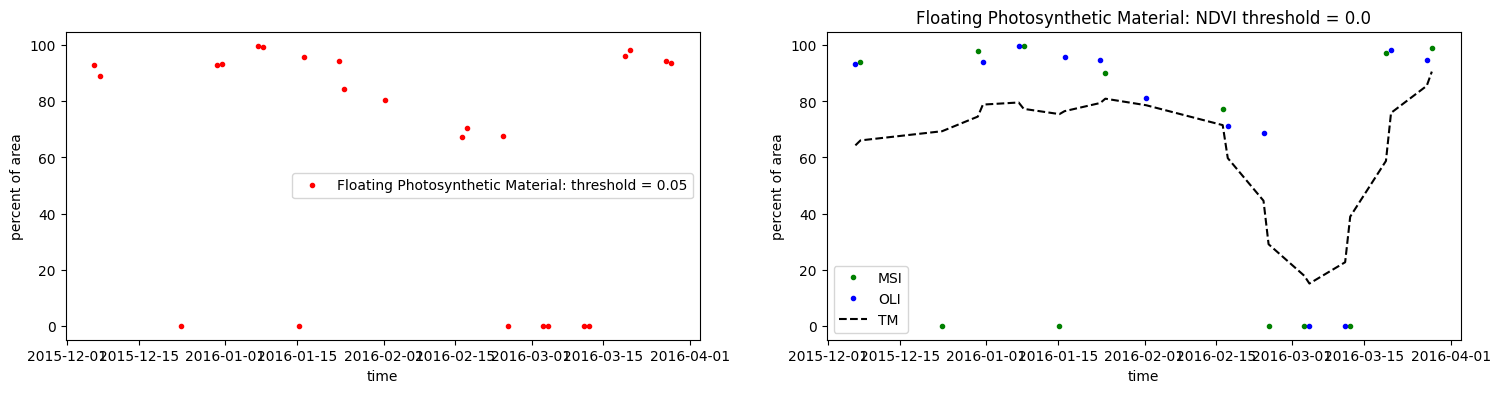

In [175]:
plt.figure(figsize=[18,4])
plt.subplot(1,2,1)

# --- extract the proporion of the area with ndvi > threshold, indicative of floating photosynthetic material, fpm ---
fpm_threshold = 0.05
ds['fpm_percent'] = 100 * ds.ndvi.where(ds.ndvi > fpm_threshold,np.nan).count(dim=('x','y')) / ds.ndvi_total_count

plt.plot(ds.where(~np.isnan(ds.fpm_percent)).time,ds.where(~np.isnan(ds.fpm_percent)).fpm_percent,
#plt.plot(ds.time,ds.ndvi_total_count,
        'r',
         linestyle="", 
         marker=".",
         label='count'
        )
plt.xlabel('time')
plt.ylabel('percent of area')
plt.legend(['Floating Photosynthetic Material: threshold = '+str(fpm_threshold)])

# --- extract the proporion of the area with ndvi > threshold, indicative of floating photosynthetic material, fpm ---
fpm_threshold = 0.0
ds['fpm_percent'] = 100 * ds.ndvi.where(ds.ndvi > fpm_threshold,np.nan).count(dim=('x','y')) / ds.ndvi_total_count

plt.subplot(1,2,2)
#plt.plot(ds.time,ds.fpm_percent              ,'k',linestyle="",marker=".",label='FPM percent')

if 'msi' in ds.data_vars:
    plt.plot(ds.time,ds.fpm_percent.where(ds.msi),'r',linestyle="",marker=".",label='FPM percent')
if 'oli' in ds.data_vars:
    plt.plot(ds.time,ds.fpm_percent.where(ds.oli),'g',linestyle="",marker=".",label='FPM percent')
if 'tm' in ds.data_vars:
    plt.plot(ds.time,ds.fpm_percent.where(ds.tm ),'b',linestyle="",marker=".",label='FPM percent')
plt.plot(ds.time,smoothfunction(ds.fpm_percent,5)(ds.time),'k',linestyle="--", marker="",label='Smoothed NDVI')  

plt.xlabel('time')
plt.ylabel('percent of area')

plt.title('Floating Photosynthetic Material: NDVI threshold = '+str(fpm_threshold))
plt.legend(['MSI','OLI','TM'])

#plt.plot(ts_ndvi_tm.time,ts_ndvi_tm,)  



plt.show()

In [149]:
# --- A Function to normalise the WQ measures ---

def normalise_water_quality_measures(ds0,np_data_dict,water_frequency_threshold=0,verbose=True,test=False):
    if test or verbose : print('Applying scale and offset to wq variables..')

    ds = ds0.copy(deep=True)   #without this the ds values do change outside of the function

    #run through all the wq measures; ds should have a dimension called 'tss_measure' and another called 'chla_measure'. 
    for mmt_type in ['tss','chla'] :
        for mmt in list(ds[mmt_type+'_measure']) :
            measurement = str(mmt.values)+'_agm'       # add the suffix - legacy of the annual geomedians used to develop the normalisation parameters
            scale  = np_data_dict[measurement]['scale']
            offset = np_data_dict[measurement]['offset']
            measurement = measurement[:measurement.find('_agm')] # removes the '_agm' suffix again!
            ds[mmt_type].loc[:,:,:,measurement] = ds[mmt_type].loc[:,:,:,measurement] * scale + offset
    
    #take the median of the tss and chla measurements from now on:
    water_frequency_threshold=0
    tss_index_list  = ds.tss_measure   # --- which tss measures to include; in practice this include them all  ----
    ds['tss_agm_med' ] = xr.where(ds.wofs_ann_pwater>water_frequency_threshold,
                                  ds.tss.loc[:,:,:,tss_index_list].median(dim=('tss_measure')),np.nan)

    chla_index_list = ds.chla_measure  # --- which chla measures to include; by default, include them all ----
    ds['chla_agm_med'] = xr.where(ds.wofs_ann_pwater>water_frequency_threshold,
                                  ds.chla.loc[:,:,:,chla_index_list].median(dim=('chla_measure')),np.nan)

    #drop excess material
    if not test:
        ds = ds.drop_vars('tss','chla')
    return ds

#### Exploring QA scores and parameters 
- I take 1.4 as a base, and use multiples of that; (2 for msi and oli, 3 for tm) 
- to bring back floating algal blooms, which will otherwise be removed, accept pixels that have an ndvi > 0.5 and ralb < 2.8
- test this on the lake victoria 'turbid' data area, for the first half of 2018
- Selection rule for ralb > -1.4 is needed with MSI to pull out cloud shadow

In [163]:
i = 0

In [164]:
#i = 15   #lake vic 2015-05-03

t = ds.time[i]
print(i)

# figure out if we are using an oli or a tm image;

oli_slice = [False,'qa_score','qa_ralb','qa_rsad','ci_score']
tm_slice  = [False,'qa_score','qa_ralb','qa_rsad','ci_score']
msi_slice = [False,'qa_score','qa_ralb','qa_rsad','ci_score']


oli_score_upper      = 1.4 * 2   # this seems best ...
msi_score_upper      = 1.4 * 2   # this seems best ...
tm_score_upper       = 1.4 * 3   # should need higher threshold for tm v oli ... not a nice step to take ..

upper_albedo = 2.0
upper_albedo = 3.0  # default filter cuts in a 2.8 so no point in going over that ... 
upper_albedo = 2.8  #lake vic 2018-04-27 benefits from relaxing to 2.8
lower_albedo = -1.4
lower_albedo = -2.
lower_albedo = -1.9 #this cuts out most cloud shadow, but can't go lower 
#lower_albedo = -1.8 starts to cut out real data in msi

upper_rsad   = 7
upper_rsad   = 6
upper_rsad   = 3
upper_rsad   = 4
upper_rsad   = 4.5
#upper_rsad   = 5 
rsad_factor = 0.4
ci_score_lower = 0
ci_cut     = 1   #one does not pick up key features


if t in list(ds_oli.time):
    oli_slice[0]        = True
    oli_timeindex       = list(ds_oli.time).index(t)
    prefix = 'qa'
    score_upper = oli_score_upper
    print('OLI')

else :
    if t in list(ds_tm.time):
        tm_slice[0]  = True
        tm_timeindex = list(ds_tm.time).index(t)
        prefix = 'qa'
        score_upper = tm_score_upper
        print('TM')
    else :
        if t in list (ds_msi.time):
            msi_slice[0]  = True
            msi_timeindex = list(ds_msi.time).index(t)
            prefix = 'qa'
            score_upper = msi_score_upper
            print('MSI')
            

# cumulative distribution stats:
start = 0;step=.05;stop=1+step

x    = np.arange(start,stop,step)
size = x.size
data = np.zeros([4,x.size])
data[0] = x
j = 0

for percent in x:
    k = 1
    string = 'Quantile = '+str(percent)+'  '
    for var in list(('ralb','rsad','score')):
        string = string + '  '+var+str(' : ')
        v      =  ds[prefix+'_'+var].sel(time=t).quantile(percent,).round(3).item()
        string = string+str(v)
        data[k,j] = v
        k = k + 1
    j = j+1
    print(string)


plt.figure(figsize=[12, 6])
plt.subplot(1,2,1)

plt.plot(data[1],data[0],'b',linestyle="--", marker=".",label='rsalb')  #ralb
plt.plot(data[2],data[0],'g',linestyle="-.", marker="X")  #rsad
plt.plot(data[3],data[0],'r',linestyle="-", marker="X")  #score
plt.axvline(x=0 ,linestyle=':',color='k')
plt.axvline(x=1.4 * 4,linestyle=':',color='r')
plt.axvline(x=1.4 * 3,linestyle=':',color='b')
plt.axvline(x=1.4 * 2,linestyle=':',color='g')

plt.title('distributions')
                 
plt.xlabel('value')
plt.ylabel('percentile')
plt.legend(['ralb','rsad','score'])

# --- parameters for the range of the plot --- 
ymin  = 0;
xmin   = np.max([np.min(data[1:,:]) * 1.5,-100])

xmax   = np.min([np.max(data[1:,:]) * 1.5,100])

plt.xlim(xmin,xmax)

plt.subplot(1,2,2)

i = i
print(i)
time = ds.time[i]
print(time.dt.year.item(),'-',time.dt.month.item(),'-',time.dt.day.item(),i,oli_slice[0],tm_slice[0])



#plt.figure(figsize=[12, 6])
if oli_slice[0]:
    print('plotting OLI points')
    plt.scatter(ds.sel(time=time).qa_rsad,ds.sel(time=time).qa_ralb,marker='.',color='c')
    plt.scatter(ds.where(ds.qa_score>0).sel(time=time).qa_rsad,
                ds.where(ds.qa_score>0).sel(time=time).qa_ralb,marker='.',color = 'b')
    plt.scatter(ds.where(ds.ci_score>ci_score_lower+upper_rsad*rsad_factor).sel(time=time).qa_rsad,
                ds.where(ds.ci_score>ci_score_lower+upper_rsad*rsad_factor).sel(time=time).qa_ralb,marker='.',color = 'r')
if tm_slice[0]: 
    print('plotting TM points')
    plt.scatter(ds.sel(time=time).qa_rsad,ds.sel(time=time).qa_ralb,marker='.',color = 'c')
    plt.scatter(ds.where(ds.qa_score>0).sel(time=time).qa_rsad,
                ds.where(ds.qa_score>0).sel(time=time).qa_ralb,marker='.',color = 'b')
    plt.scatter(ds.where(ds.ci_score>ci_score_lower+upper_rsad*rsad_factor).sel(time=time).qa_rsad,
                ds.where(ds.ci_score>ci_score_lower+upper_rsad*rsad_factor).sel(time=time).qa_ralb,marker='.',color = 'r')
if msi_slice[0]: 
    print('plotting MSI points')
    plt.scatter(ds.sel(time=time).qa_rsad,ds.sel(time=time).qa_ralb,marker='.',color = 'c')
    plt.scatter(ds.where(ds.qa_score>0).sel(time=time).qa_rsad,
                ds.where(ds.qa_score>0).sel(time=time).qa_ralb,marker='.',color = 'b')
    plt.scatter(ds.where(ds.ci_score>ci_score_lower+upper_rsad*rsad_factor).sel(time=time).qa_rsad,
                ds.where(ds.ci_score>ci_score_lower+upper_rsad*rsad_factor).sel(time=time).qa_ralb,marker='.',color = 'r')


plt.plot(0,0,marker='d',color='r')
t = np.linspace(0,2*np.pi,100)
r0 = 1.4 

x,y = np.cos(t)/rsad_factor,np.sin(t)
#plt.plot(x*1*r1,y*r0,linestyle='-.',color='g')
#plt.plot(x*2*r1,y*2*r0,linestyle='--',color='b')
#plt.plot(x*score_upper*r1,y*score_upper*r0,linestyle='--',color='r')
plt.plot(score_upper*x,score_upper*y,linestyle='dotted',color='r')
plt.plot(2*r0*x,2*r0*y,linestyle='dotted',color='g')
#plot the nominal change index = 0 curve
y = np.linspace(-5,5,30)
plt.plot(y**2,y,linestyle='dotted',color='k')

plt.axvline(x=0,color='r',linestyle=':')
plt.axvline(x=0+2*r0/rsad_factor,color='g',linestyle=':')
plt.axvline(x=upper_rsad,color='k',linestyle='-')
plt.axhline(y=0-2*r0,color='g',linestyle=':')
plt.axhline(y=0+2*r0,color='g',linestyle=':')
plt.axhline(y=lower_albedo,color='k',linestyle='-')
plt.axhline(y=upper_albedo,color='k',linestyle='-')

plt.xlim([0,40])
plt.ylim([-20,20])

plt.show()

print('original data')    

if oli_slice[0] == True :
    rgb(ds_oli,
        #    col='time',
        #    col_wrap = 4,
        bands=['oli04','oli03','oli02'],
        index =oli_timeindex,
        index_dim='time',
        #aspect = .8,
        #percentile_stretch = (.1,.65)
        robust = True
       )

if tm_slice[0] == True:
    rgb(ds_tm,
        #    col='time',
        #    col_wrap = 4,
        bands=['tm03','tm02','tm01'],
        index =tm_timeindex,
        index_dim='time',
        #aspect = .8,
        #percentile_stretch = (.1,.65)
        robust = True
       )
if msi_slice[0] == True:
    rgb(ds_msi,
        #    col='time',
        #    col_wrap = 4,
        bands=['msi04','msi03','msi02'],
        index =msi_timeindex,
        index_dim='time',
        #aspect = .8,
        #percentile_stretch = (.1,.65)
        robust = True
       )


if oli_slice[0]: 
    qa_var = oli_slice[1]
    qa_ralb = oli_slice[2]
    qa_rsad = oli_slice[3]
    qa_ci   = oli_slice[4]
    rgbbands=['oli04','oli03','oli01']
    ndvibands=['oli05','oli04']
    cutoff = score_upper
    
if tm_slice[0] : 
    qa_var = tm_slice[1]
    qa_ralb = tm_slice[2]
    qa_rsad = tm_slice[3]
    qa_ci   = tm_slice[4]
    rgbbands=['tm03','tm02','tm01']
    ndvibands=['tm04','tm03']
    cutoff = tm_score_upper

if msi_slice[0] : 
    qa_var = msi_slice[1]
    qa_ralb = msi_slice[2]
    qa_rsad = msi_slice[3]
    qa_ci   = msi_slice[4]
    rgbbands=['msi04','msi03','msi02']
    ndvibands=['msi8a','msi04']
    cutoff = msi_score_upper
    
print('QA var:  ',qa_var, rgbbands)


# --- just the qa variable ---
plt.show()
print('default filter')    

rgb(ds.where(ds[qa_var]>0,np.nan),
#rgb(ds.where(np.logical_and(np.logical_and(ds[qa_var]<cutoff,ds[qa_ralb]>lower_albedo),ds[qa_ralb]<upper_albedo),np.nan),
#rgb(ds.where(np.logical_and(np.logical_and(ds[qa_ralb]>lower_albedo,ds[qa_ralb]<upper_albedo),ds[qa_rsad]>upper_rsad),np.nan),
#rgb(ds.where(np.logical_and(np.logical_and(ds[qa_ci]>0,ds[qa_var]>cutoff),ds[qa_rsad]>0),np.nan),
#    col='time',
#    col_wrap = 4,
    bands=rgbbands,
    index =i,
    index_dim='time',
    robust=True,
    #aspect = .8,
    #percentile_stretch = (0.1,.99)
    )
plt.show()

# --- qa variable with additional overlays to fine-tune.. ---
print('default filter further constrained by albedo and spectral angle deviation ')    

rgb(ds.where(np.logical_and
             (
             np.logical_and(ds[qa_var]>0,ds[qa_rsad]<upper_rsad),
             np.logical_and(ds[qa_ralb]>lower_albedo,ds[qa_ralb]<upper_albedo)
             )
             ,np.nan),
#rgb(ds.where(np.logical_and(np.logical_and(ds[qa_ralb]>lower_albedo,ds[qa_ralb]<upper_albedo),ds[qa_rsad]>upper_rsad),np.nan),
#rgb(ds.where(np.logical_and(np.logical_and(ds[qa_ci]>0,ds[qa_var]>cutoff),ds[qa_rsad]>0),np.nan),
#    col='time',
#    col_wrap = 4,
    bands=rgbbands,
    index =i,
    index_dim='time',
    robust=True,
    #aspect = .8,
    #percentile_stretch = (0.1,.99)
    )

plt.show()

# --- no qa variable; additional overlays replace... ---

print('simple filter constrained independently by albedo and spectral angle deviation ')    

rgb(ds.where(np.logical_and
             (
             np.logical_and(True,ds[qa_rsad]<upper_rsad),
             np.logical_and(ds[qa_ralb]>lower_albedo,ds[qa_ralb]<upper_albedo)
             )
             ,np.nan),
#rgb(ds.where(np.logical_and(np.logical_and(ds[qa_ralb]>lower_albedo,ds[qa_ralb]<upper_albedo),ds[qa_rsad]>upper_rsad),np.nan),
#rgb(ds.where(np.logical_and(np.logical_and(ds[qa_ci]>0,ds[qa_var]>cutoff),ds[qa_rsad]>0),np.nan),
#    col='time',
#    col_wrap = 4,
    bands=rgbbands,
    index =i,
    index_dim='time',
    robust=True,
    #aspect = .8,
    #percentile_stretch = (0.1,.99)
    )

plt.show()
print('default further constrained by albedo')    

rgb(ds.where(np.logical_and
             (
                 np.logical_and(ds[qa_ralb]>lower_albedo,ds[qa_ralb]<upper_albedo),
                 ds[qa_var]>0
             )
             ,np.nan),
#rgb(ds.where(np.logical_and(np.logical_and(ds[qa_ralb]>lower_albedo,ds[qa_ralb]<upper_albedo),ds[qa_rsad]>upper_rsad),np.nan),
#rgb(ds.where(np.logical_and(np.logical_and(ds[qa_ci]>0,ds[qa_var]>cutoff),ds[qa_rsad]>0),np.nan),
#    col='time',
#    col_wrap = 4,
    bands=rgbbands,
    index =i,
    index_dim='time',
    robust=True,
    #aspect = .8,
    #percentile_stretch = (0.1,.99)
    )

plt.show()
print('default filter further constrained by rsad')    

rgb(ds.where(np.logical_and(ds[qa_rsad]<upper_rsad,ds[qa_var]>0),np.nan),
#rgb(ds.where(np.logical_and(np.logical_and(ds[qa_ralb]>lower_albedo,ds[qa_ralb]<upper_albedo),ds[qa_rsad]>upper_rsad),np.nan),
#rgb(ds.where(np.logical_and(np.logical_and(ds[qa_ci]>0,ds[qa_var]>cutoff),ds[qa_rsad]>0),np.nan),
#    col='time',
#    col_wrap = 4,
    bands=rgbbands,
    index =i,
    index_dim='time',
    robust=True,
    #aspect = .8,
    #percentile_stretch = (0.1,.99)
    )


plt.show()

print('change indicator; high rsad, low ralb')    
# --- change indicator ---
#rgb(ds.where(np.logical_and(ds[qa_var]<cutoff,ds[qa_ralb]>lower_albedo),np.nan),
#rgb(ds.where(np.logical_and(np.logical_and(ds[qa_ralb]>lower_albedo,ds[qa_ralb]<upper_albedo),ds[qa_rsad]>upper_rsad),np.nan),
ci_cut = 0
#ds['change_inidicated'] = ds.where(np.logical_and
#                               (
#                                np.logical_and(ds[qa_rsad]>upper_rsad,ds[qa_var]>cutoff),
#                                ds[qa_ralb]<upper_albedo
#                               ),
#                               np.nan)

rgb(ds.where(np.logical_and(
                            ds.ci_score>ci_score_lower+upper_rsad*rsad_factor,
                            ds[qa_var]<=0
                            ),np.nan),
#    col='time',
#    col_wrap = 4,
    bands=rgbbands,
    index =i,
    index_dim='time',
    robust=True,
    #aspect = .8,
    #percentile_stretch = (0.1,.99)
    )

plt.show()
print('ndvi')    

ndvi_threshold = 0.1
ndvi = (ds[ndvibands[0]]-ds[ndvibands[1]])/(ds[ndvibands[0]]+ds[ndvibands[1]])
xr.where(ndvi>ndvi_threshold,ndvi,np.nan).isel(time=i).plot(robust=True)

# --- photosynthetic surface material --- 
#ds['psm'] = ds.where(np.logical_and(ndvi > ndvi_threshold,ds['change_indicated'] == True),True,False)
                                    

i = i + 1
#i = 



0


AttributeError: 'str' object has no attribute 'time'